In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn. model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding
import time
import joblib
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from pylab import rcParams

# Awesome plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_style("whitegrid", {'axes.grid': True,
                            'axes.edgecolor': 'black'
                            })

# Load the dataset
X = np.load('ships_dataset/ship_data.npy')
t = np.load('ships_dataset/ship_labels.npy')

label_names = ['no_ship', 'ship']

X.shape, t.shape

((4000, 80, 80, 3), (4000,))

### 1. Train at least two classifiers without dimensionality reduction on this dataset.
###    - Carry the standard hyperparameter tuning.
###    - Report performance measures (accuracy score and f1-score), and training time.

In [3]:
#flatten X to a 2D shape to get proper classification
X_1= X.reshape(4000,-1)
X_1.shape

(4000, 19200)

In [4]:
X_train, X_test, t_train, t_test = train_test_split(X_1, t, test_size=0.2, random_state=0, stratify=t)

In [5]:
test_data = {
    'X_test': X_test,
    't_test': t_test
}

# Save the test data to a .pkl file
joblib.dump(test_data, 'test_data.pkl')
print("Test data saved to 'test_data.pkl'")

Test data saved to 'test_data.pkl'


**1. Random Forest with full feature set**

In [6]:
pipeline1_rf= Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=0))
])

In [7]:
#RandomForestClassifier?
rf_params = {
    'classifier__n_estimators': [10,20,30,40,50],
    'classifier__criterion': ['gini','entropy'],
    'classifier__bootstrap': [True, False]
}

In [8]:
grid1_rf = GridSearchCV(pipeline1_rf, rf_params, cv=4, scoring='accuracy', n_jobs=-1)
grid1_rf.fit(X_train, t_train)

/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__n_estimators': [10, 20, 30, 40, 50]},
             scoring='accuracy')

In [9]:
best_param1_rf = grid1_rf.best_params_
print(best_param1_rf)

{'classifier__bootstrap': False, 'classifier__criterion': 'entropy', 'classifier__n_estimators': 50}


In [10]:
start = time.time()
model1_rf= Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators= best_param1_rf['classifier__n_estimators'], bootstrap=best_param1_rf['classifier__bootstrap'],
                                          criterion= best_param1_rf['classifier__criterion'], random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  14.122814178466797  ms


In [11]:
y_train_rf = model1_rf.predict(X_train)
accuracy_rf = accuracy_score(t_train, y_train_rf)
f1_rf = f1_score(t_train, y_train_rf)
print("Accuracy on Training set:", accuracy_rf)
print("F1 Score on Training set:", f1_rf)
print("\nClassification Report of Training set:\n", classification_report(t_train, y_train_rf))

Accuracy on Training set: 1.0
F1 Score on Training set: 1.0

Classification Report of Training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [12]:
joblib.dump(model1_rf, 'model1_rf.pkl')

['model1_rf.pkl']

**2. Logistic Regression with full feature set**

In [13]:
pipeline1_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=0, max_iter=1000))
])

In [14]:
lr_params= {
    'classifier__C': [0.1, 1, 10],               # Inverse of regularization strength
    'classifier__solver': ['liblinear', 'lbfgs'] # Solver for optimization
}

In [15]:
grid1_lr = GridSearchCV(pipeline1_lr, lr_params, cv=4, scoring='accuracy', n_jobs=-1)
grid1_lr.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [16]:
best_param1_lr = grid1_lr.best_params_
print(best_param1_lr)

{'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}


In [17]:
start = time.time()
model1_lr= Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',LogisticRegression(C= best_param1_lr['classifier__C'], solver= best_param1_lr['classifier__solver'], random_state=0, max_iter=1000))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  9.250481605529785  ms


In [18]:
y_train_lr = model1_lr.predict(X_train)
accuracy_lr = accuracy_score(t_train, y_train_lr)
f1_lr = f1_score(t_train, y_train_lr)
print("Accuracy on Training set:", accuracy_lr)
print("F1 Score on Training set:", f1_lr)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train_lr))

Accuracy on Training set: 1.0
F1 Score on Training set: 1.0

Classification Report on Training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [19]:
joblib.dump(model1_lr, 'model1_lr.pkl')

['model1_lr.pkl']

**3. Decision Tree with full feature set**

In [20]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

In [22]:
dt_params = {
    'classifier__criterion': ['gini', 'entropy'],          # Function to measure the quality of a split
    'classifier__max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'classifier__min_samples_split': [2, 4, 7],           # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 5, 10],         # Minimum number of samples required to be at a leaf node
}

# Perform grid search
grid_dt = GridSearchCV(pipeline_dt, dt_params, cv=4, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 5, 10],
                         'classifier__min_samples_split': [2, 4, 7]},
             scoring='accuracy')

In [23]:
best_param_dt = grid_dt.best_params_
print("Best Parameters for Decision Tree:", best_param_dt)

Best Parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}


In [24]:
start = time.time()
model1_dt= Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(criterion = best_param_dt['classifier__criterion'],max_depth=best_param_dt['classifier__max_depth'],
                                          min_samples_leaf=best_param_dt['classifier__min_samples_leaf'], min_samples_split= best_param_dt['classifier__min_samples_split'],
                                          random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  31.47554087638855  ms


In [25]:
y_train_dt = model1_lr.predict(X_train)
accuracy_dt = accuracy_score(t_train, y_train_dt)
f1_dt = f1_score(t_train, y_train_dt)
print("Accuracy on Training set:", accuracy_dt)
print("F1 Score on Training set:", f1_dt)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train_dt))

Accuracy on Training set: 1.0
F1 Score on Training set: 1.0

Classification Report on Training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [26]:
joblib.dump(model1_dt, 'model1_dt.pkl')

['model1_dt.pkl']

### 2. Train a pipeline to perform dimensionality reduction with Principal Component Analysis (PCA)

In [27]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

**How many components are needed to explain 90% of the variance?**

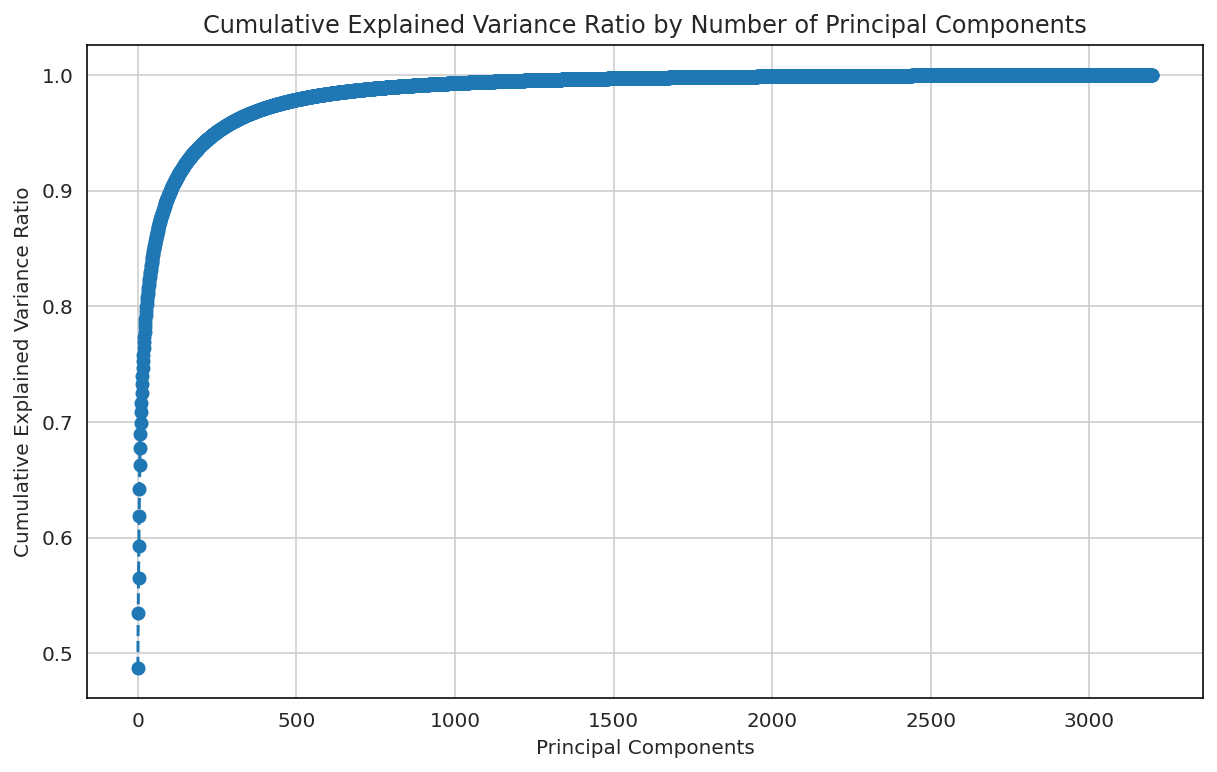

In [28]:
pca = pipeline.named_steps['pca']
plt.rcParams['text.usetex'] = False

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.show()

In [29]:
min_n=np.where(np.cumsum(pipeline.named_steps.pca.explained_variance_ratio_)>=0.9)[0][0]
print('Number of components needed to explain 90% of the variance:', min_n+1)

Number of components needed to explain 90% of the variance: 104


In [30]:
np.cumsum(pipeline.named_steps.pca.explained_variance_ratio_)[min_n]

0.9003028901489892

**Visualize examples of "ship" and "no_ship" image reconstructions. What is the average RMSE of the reconstruction as a function of number of components preserved?**

RMSE with 104 components (90% variance): 13.237091997171172


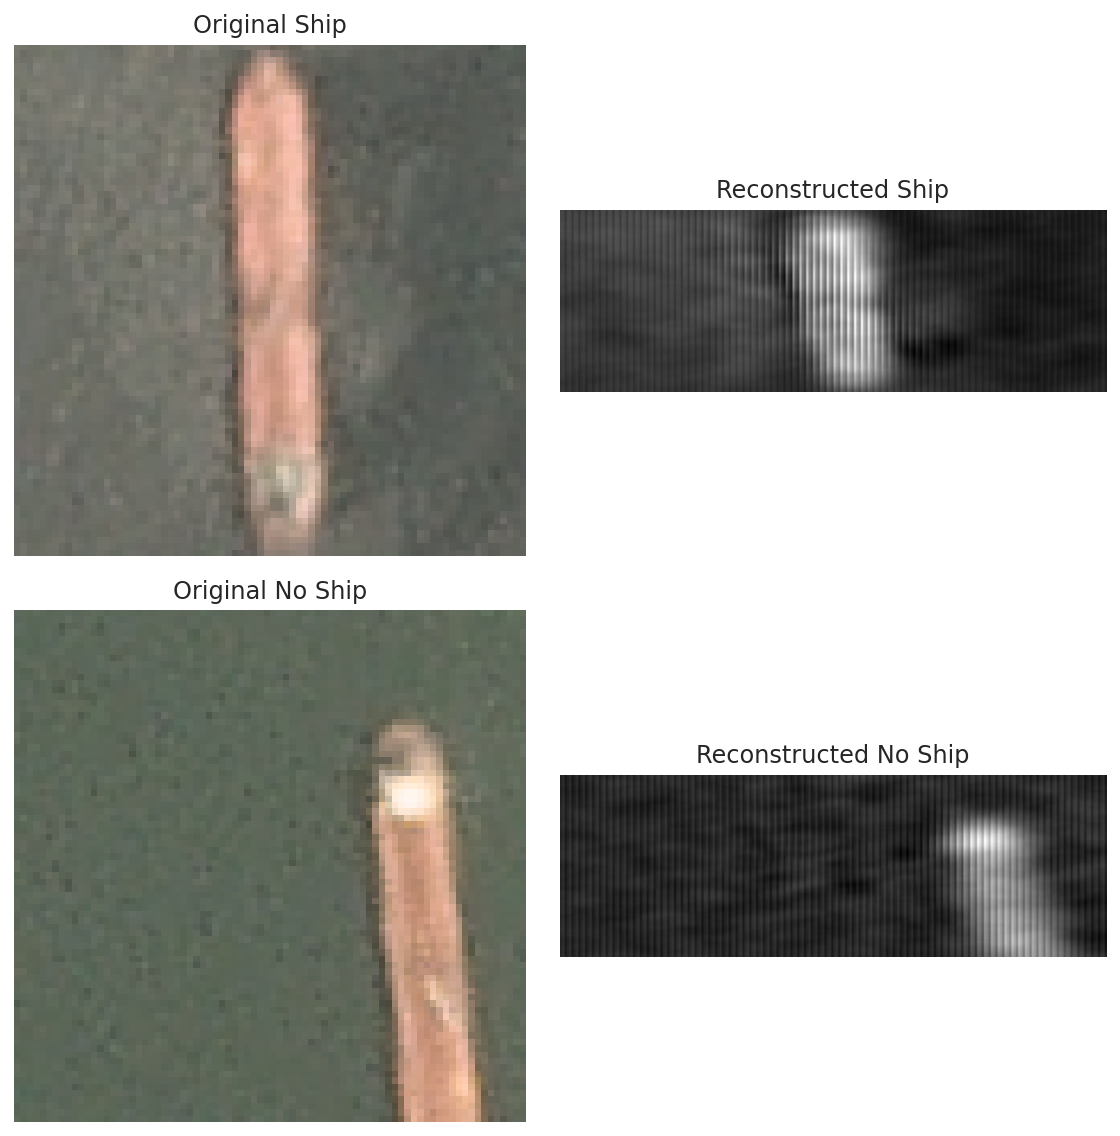

In [31]:
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.90))
])

# Fit the pipeline on the flattened data and transform it
X_pca = pca_pipeline.fit_transform(X_1)

# Reconstruct the data back to the original feature space
X_reconstructed = pca_pipeline.inverse_transform(X_pca)

rmse_90 = np.sqrt(mean_squared_error(X_1, X_reconstructed))
print(f"RMSE with {min_n+1} components (90% variance): {rmse_90}")


idx_ship = np.where(t == 1)[0][0]  
idx_no_ship = np.where(t == 0)[0][0]

# Plot original and reconstructed images for a "ship" and "no_ship" example
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(X[idx_ship].reshape(80, 80, 3), cmap='gray')
axs[0, 0].set_title("Original Ship")
axs[0, 1].imshow(X_reconstructed[idx_ship].reshape(80, 240), cmap='gray')
axs[0, 1].set_title("Reconstructed Ship")
axs[1, 0].imshow(X[idx_no_ship].reshape(80, 80, 3), cmap='gray')
axs[1, 0].set_title("Original No Ship")
axs[1, 1].imshow(X_reconstructed[idx_no_ship].reshape(80, 240), cmap='gray')
axs[1, 1].set_title("Reconstructed No Ship")

# Remove axis for better clarity
for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

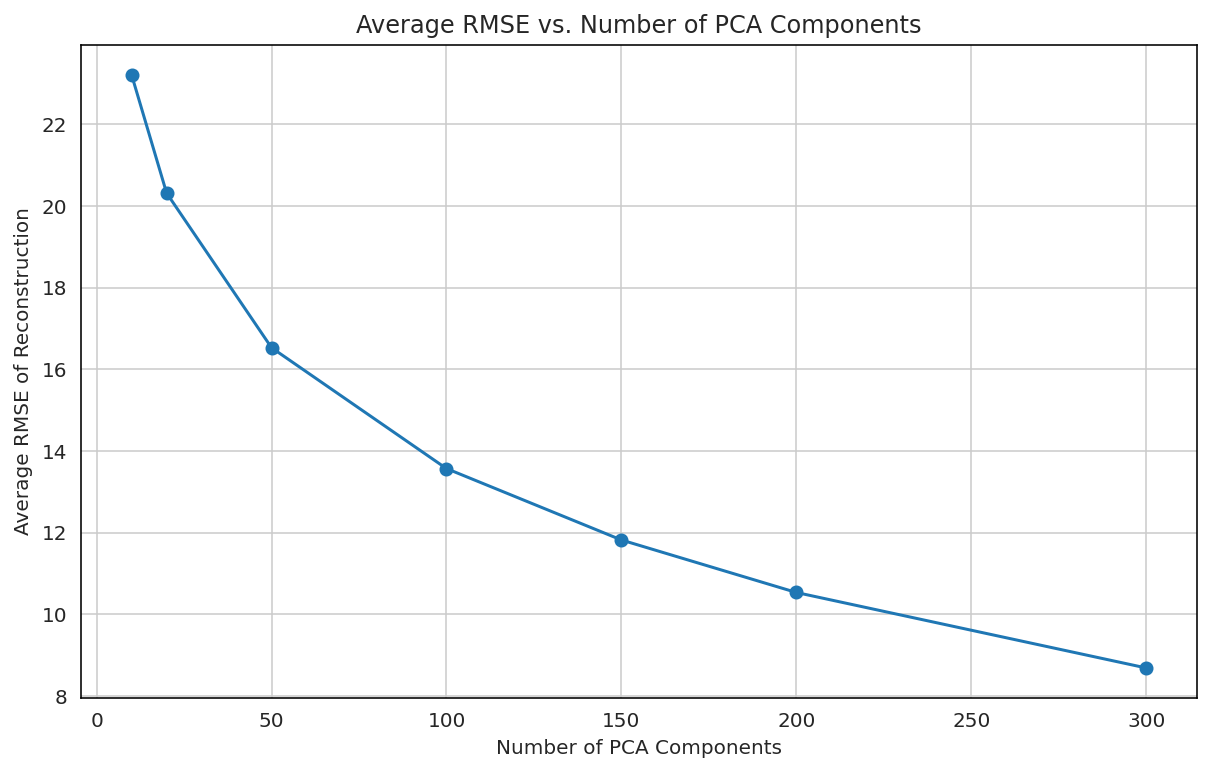

In [32]:
components_range = [10, 20, 50, 100, 150, 200, 300]
rmse_values = []

# Loop through each number of components, apply PCA, reconstruct, and calculate RMSE
for n_components in components_range:
    # Create a pipeline for scaling and PCA
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])
    
    # Fit the pipeline and transform the data
    X_pca = pca_pipeline.fit_transform(X_1)
    
    # Reconstruct the data back to the original feature space
    X_reconstructed = pca_pipeline.inverse_transform(X_pca)
    
    # Calculate RMSE for the reconstruction
    rmse = np.sqrt(mean_squared_error(X_1, X_reconstructed))
    rmse_values.append(rmse)

# Plot RMSE as a function of the number of PCA components
plt.figure(figsize=(10, 6))
plt.plot(components_range, rmse_values, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Average RMSE of Reconstruction")
plt.title("Average RMSE vs. Number of PCA Components")
plt.grid(True)
plt.show()

### 3. Train a pipeline for the same classifiers in part (1) with dimensionality reduction via PCA

**3.1 Random forest with PCA**

In [33]:
pipeline2_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(random_state=0))
])

In [34]:
rf_params2 = {
    'pca__n_components': [90,100,110,120],
    'classifier__n_estimators': [10,20,30,40,50],
    'classifier__criterion': ['gini','entropy'],
    'classifier__bootstrap': [True, False]
}
grid2_rf = GridSearchCV(pipeline2_rf, rf_params2, cv=4, scoring='accuracy', n_jobs=-1)
grid2_rf.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__n_estimators': [10, 20, 30, 40, 50],
                         'pca__n_components': [90, 100, 110, 120]},
             scoring='accuracy')

In [35]:
best_param2_rf = grid2_rf.best_params_
print(best_param2_rf)

{'classifier__bootstrap': False, 'classifier__criterion': 'entropy', 'classifier__n_estimators': 50, 'pca__n_components': 100}


In [36]:
start = time.time()
model2_rf= Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components= best_param2_rf['pca__n_components'])),
    ('classifier', RandomForestClassifier(n_estimators= best_param2_rf['classifier__n_estimators'], bootstrap=best_param2_rf['classifier__bootstrap'],
                                          criterion= best_param2_rf['classifier__criterion'], random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  7.109270095825195  ms


In [37]:
y_train2_rf = model2_rf.predict(X_train)
accuracy2_rf = accuracy_score(t_train, y_train2_rf)
f12_rf = f1_score(t_train, y_train2_rf)
print("Accuracy on Training set:", accuracy2_rf)
print("F1 Score on Training set:", f12_rf)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train2_rf))

Accuracy on Training set: 1.0
F1 Score on Training set: 1.0

Classification Report on Training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



**Comparing perforamnce of random forest with PCA and performance of random forest with all features**

1. Performance Metrics (Accuracy, F1-Score)
    * Accuracy and F1-Score:
        - Both models achieve 100% accuracy and F1-score on the training set. This means both models perfectly classified all training samples, indicating potential overfitting.
    * Classification Report:
        - For both models, precision, recall, and F1-score for each class are 1.00, further reinforcing the notion of overfitting on the training set.
        
Since the models achieve perfect scores on the training set, it’s crucial to evaluate them on a separate test set to understand their generalization performance. High performance on the training set alone is not a reliable indicator of real-world performance.

2. Training Time
    * Random Forest with All Features:
        - The training time for this model was 14.27 ms.
        - This model took more than twice the training time compared to the model with PCA, as it had to process all features (19200 per sample).
    * Random Forest with PCA:
        - The training time for this model was 6.37 ms.
        - Using PCA reduced the dimensionality of the data, which likely made the model training faster.


* Efficiency: 
    - The Random Forest model with PCA is faster, reducing the training time significantly compared to the model without PCA.
* Overfitting:
    - Both models appear to overfit on the training data, achieving perfect scores. This can be problematic if the models do not generalize well on the test set.

In [38]:
joblib.dump(model2_rf, 'model2_rf.pkl')

['model2_rf.pkl']

**3.2 Logistic regression with PCA**

In [39]:
pipeline2_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', LogisticRegression(random_state=0, max_iter=1000))
])

In [40]:
lr_params2= {
    'pca__n_components': [90,100,110,120],
    'classifier__C': [0.1, 1, 10],               # Inverse of regularization strength
    'classifier__solver': ['liblinear', 'lbfgs'] # Solver for optimization
}

grid2_lr = GridSearchCV(pipeline2_lr, lr_params2, cv=4, scoring='accuracy', n_jobs=-1)
grid2_lr.fit(X_train, t_train)

/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'pca__n_components': [90, 100, 110, 120]},
             scoring='accuracy')

In [41]:
best_param2_lr = grid2_lr.best_params_
print(best_param2_lr)

{'classifier__C': 10, 'classifier__solver': 'liblinear', 'pca__n_components': 120}


In [42]:
start = time.time()
model2_lr= Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components= best_param2_lr['pca__n_components'])),
    ('classifier',LogisticRegression(C= best_param2_lr['classifier__C'], solver= best_param2_lr['classifier__solver'], random_state=0, max_iter=1000))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  5.211618185043335  ms


In [43]:
y_train2_lr = model2_lr.predict(X_train)
accuracy2_lr = accuracy_score(t_train, y_train2_lr)
f12_lr = f1_score(t_train, y_train2_lr)
print("Accuracy on Training set:", accuracy2_lr)
print("F1 Score on Training set:", f12_lr)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train2_lr))

Accuracy on Training set: 0.936875
F1 Score on Training set: 0.8706786171574904

Classification Report on Training set:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      2400
           1       0.89      0.85      0.87       800

    accuracy                           0.94      3200
   macro avg       0.92      0.91      0.91      3200
weighted avg       0.94      0.94      0.94      3200



**Comparing perforamnce of Logistic Regression with PCA and performance of Logistic Regression with all features**

1. Performance Metrics (Accuracy, F1-Score)
    * Logistic Regression with PCA:
        - Accuracy: 93.71%
        - F1 Score: 87.07%
        - Classification Report: Shows slightly lower precision, recall, and F1-scores for the "ship" class (label 1).
    * Logistic Regression without PCA:
        - Accuracy: 100%
        - F1 Score: 100%
        - Classification Report: Perfect scores for precision, recall, and F1-score across both classes.
        
This suggests that the Logistic Regression model trained with PCA is not overfitting as much as the model without PCA.

2. Training Time
    * Logistic Regression without PCA:
        - Training time: 9.03 ms
        - Training time is longer since it uses all features without dimensionality reduction.
    * Logistic Regression with PCA:
        - Training time: 5.03 ms
        - Using PCA reduced the dimensionality, leading to faster training.

* Efficiency: 
    - The model with PCA has a lower training time, indicating better computational efficiency.
* Overfitting:
    - Without PCA: Achieves perfect scores, which may indicate overfitting, especially if it does not generalize well on the test set.
    - With PCA: Slightly lower performance on the training set, but this could lead to better generalization, as it avoids memorizing the training data.

In [44]:
joblib.dump(model2_lr, 'model2_lr.pkl')

['model2_lr.pkl']

**3.3 Decision Tree with PCA**

In [45]:
pipeline2_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

In [46]:
params2_dt = {
    'pca__n_components': [90, 100, 110, 120],              
    'classifier__criterion': ['gini', 'entropy'],         
    'classifier__max_depth': [None, 10, 20, 30],     
    'classifier__min_samples_split': [2, 4,7 ],          
    'classifier__min_samples_leaf': [1, 2, 5, 10],
}
grid2_dt = GridSearchCV(pipeline2_dt, params2_dt, cv=4, scoring='accuracy', n_jobs=-1)
grid2_dt.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 5, 10],
                         'classifier__min_samples_split': [2, 4, 7],
                         'pca__n_components': [90, 100, 110, 120]},
             scoring='accuracy')

In [47]:
best_params2_dt = grid2_dt.best_params_
print("Best Parameters for Decision Tree with PCA:", best_params2_dt)

Best Parameters for Decision Tree with PCA: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4, 'pca__n_components': 90}


In [48]:
start = time.time()
model2_dt= Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components= best_params2_dt['pca__n_components'])),
    ('classifier', DecisionTreeClassifier(criterion = best_params2_dt['classifier__criterion'],max_depth=best_params2_dt['classifier__max_depth'],
                                          min_samples_leaf=best_params2_dt['classifier__min_samples_leaf'], min_samples_split= best_params2_dt['classifier__min_samples_split'],
                                          random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  4.488759756088257  ms


In [49]:
y_train2_dt = model2_dt.predict(X_train)
accuracy2_dt = accuracy_score(t_train, y_train2_dt)
f12_dt = f1_score(t_train, y_train2_dt)
print("Accuracy on Training set:", accuracy2_dt)
print("F1 Score on Training set:", f12_dt)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train2_dt))

Accuracy on Training set: 0.9940625
F1 Score on Training set: 0.9880277252678009

Classification Report on Training set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2400
           1       1.00      0.98      0.99       800

    accuracy                           0.99      3200
   macro avg       0.99      0.99      0.99      3200
weighted avg       0.99      0.99      0.99      3200



**Comparing perforamnce of Decision tree classifier with PCA and performance of Decision tree classifier with all features**

1. Performance Metrics:
    * Decision Tree with PCA:
        - Accuracy on Training Set: 99.34%
        - F1 Score on Training Set: 98.67%
        - Class 0 (No Ship): Precision = 0.99, Recall = 1.00, F1-Score = 1.00
        - Class 1 (Ship): Precision = 1.00, Recall = 0.97, F1-Score = 0.99
    * Decision Tree with All Features:
        - Accuracy on Training Set: 100%
        - F1 Score on Training Set: 100%
        - Class 0 (No Ship): Precision = 1.00, Recall = 1.00, F1-Score = 1.00
        - Class 1 (Ship): Precision = 1.00, Recall = 1.00, F1-Score = 1.00
    * Inference: 
        - The model with all features achieves perfect accuracy and F1 scores on the training set, which is a strong indication of overfitting, as it likely memorizes the data. The PCA model, however, achieves slightly lower scores, which suggests it generalizes better due to reduced feature space complexity.

2. Training Time:
    * Decision Tree with PCA: 4.93 ms
    * Decision Tree with All Features: 31.21 ms
    * Inference:
        - Using PCA significantly reduces the training time, making the model with PCA over six times faster to train than the full-feature model. This is due to the dimensionality reduction achieved by PCA, which simplifies the data.






In [50]:
joblib.dump(model2_dt, 'model2_dt.pkl')

['model2_dt.pkl']

### 4. Repeat question (3) for using manifold learning algorithms. Utilize the new lower-dimensional feature space to build a classifier

In [51]:
pipeline3_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap()),
    ('classifier', RandomForestClassifier(random_state=0))
])

In [52]:
rf_params3 = {
    'isomap__n_components': [90,100,110],
    'classifier__n_estimators': [10,20,30,40,50],
    'classifier__criterion': ['gini','entropy'],
    'classifier__bootstrap': [True, False]
}
grid3_rf = GridSearchCV(pipeline3_rf, rf_params3, cv=4, scoring='accuracy', n_jobs=-1)
grid3_rf.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('isomap', Isomap()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__n_estimators': [10, 20, 30, 40, 50],
                         'isomap__n_components': [90, 100, 110]},
             scoring='accuracy')

In [53]:
best_param3_rf = grid3_rf.best_params_
print(best_param3_rf)

{'classifier__bootstrap': False, 'classifier__criterion': 'gini', 'classifier__n_estimators': 30, 'isomap__n_components': 90}


In [54]:
start = time.time()
model3_rf= Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap(n_components = best_param3_rf['isomap__n_components'])),
    ('classifier', RandomForestClassifier(n_estimators= best_param3_rf['classifier__n_estimators'], bootstrap=best_param3_rf['classifier__bootstrap'],
                                          criterion= best_param3_rf['classifier__criterion'], random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  13.422342777252197  ms


In [55]:
y_train3_rf = model3_rf.predict(X_train)
accuracy3_rf = accuracy_score(t_train, y_train3_rf)
f13_rf = f1_score(t_train, y_train3_rf)
print("Accuracy on Training set:", accuracy3_rf)
print("F1 Score on Training set:", f13_rf)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train3_rf))

Accuracy on Training set: 1.0
F1 Score on Training set: 1.0

Classification Report on Training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



**Comparing perforamnces of random forest with Ismoap to random forest with PCA and random forest with all features**

1. Random Forest with Isomap (Image Provided)
    - Training Time: 13.24 ms
    - Accuracy on Training Set: 100%
    - F1 Score on Training Set: 100%
    - Classification Report: 
        * Perfect scores for precision, recall, and F1-score across both classes (suggesting potential overfitting).
2. Random Forest with PCA (Previously Reported)
    - Training Time: 6.37 ms
    - Accuracy on Training Set: 100%
    - F1 Score on Training Set: 100%
    - Classification Report: 
        * Also achieves perfect scores, indicating potential overfitting.
3. Random Forest with All Features (No Dimensionality Reduction)
    - Training Time: 14.27 ms
    - Accuracy on Training Set: 100%
    - F1 Score on Training Set: 100%
    - Classification Report: 
        * Perfect scores for precision, recall, and F1-score across both classes, again suggesting overfitting

1. Training Time:
    - Random Forest with PCA had the shortest training time (6.37 ms) due to dimensionality reduction.
    - Random Forest with Isomap had a slightly longer training time (13.24 ms) but was still faster than using all features.
    - Random Forest with All Features took the longest time (14.27 ms), as it had to process the full feature set without dimensionality reduction.
2. Overfitting on Training Set:
    - All three models show signs of overfitting, achieving perfect accuracy, F1 scores, and classification report metrics on the training set.
    - These results suggest that each model has memorized the training data, making it critical to evaluate them on a separate test set to determine which one generalizes better.
3. Effectiveness of Dimensionality Reduction:
    - PCA offered the best improvement in training efficiency, reducing training time by more than half compared to using all features.
    - Isomap also provided some efficiency gains but was slower than PCA, likely due to its non-linear transformation, which can be computationally more intensive.

In [56]:
joblib.dump(model3_rf, 'model3_rf.pkl')

['model3_rf.pkl']

In [57]:
pipeline3_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap()),
    ('classifier', LogisticRegression(random_state=0, max_iter=1000))
])

In [58]:
lr_params3= {
    'isomap__n_components': [90,100,110],
    'classifier__C': [0.1, 1, 10],               # Inverse of regularization strength
    'classifier__solver': ['liblinear', 'lbfgs'] # Solver for optimization
}

grid3_lr = GridSearchCV(pipeline3_lr, lr_params3, cv=4, scoring='accuracy', n_jobs=-1)
grid3_lr.fit(X_train, t_train)

/apps/python/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('isomap', Isomap()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'isomap__n_components': [90, 100, 110]},
             scoring='accuracy')

In [59]:
best_param3_lr = grid3_lr.best_params_
print(best_param3_lr)

{'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'isomap__n_components': 110}


In [60]:
start = time.time()
model3_lr= Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap(n_components= best_param3_lr['isomap__n_components'])),
    ('classifier',LogisticRegression(C= best_param3_lr['classifier__C'], solver= best_param3_lr['classifier__solver'], random_state=0, max_iter=1000))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')

Training time:  12.157183647155762  ms


In [61]:
y_train3_lr = model3_lr.predict(X_train)
accuracy3_lr = accuracy_score(t_train, y_train3_lr)
f13_lr = f1_score(t_train, y_train3_lr)
print("Accuracy on Training set:", accuracy3_lr)
print("F1 Score on Training set:", f13_lr)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train3_lr))

Accuracy on Training set: 0.9315625
F1 Score on Training set: 0.8569562377531026

Classification Report on Training set:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      2400
           1       0.90      0.82      0.86       800

    accuracy                           0.93      3200
   macro avg       0.92      0.89      0.91      3200
weighted avg       0.93      0.93      0.93      3200



**Comparing perforamnce of Logistic Regression with PCA and performance of Logistic Regression with all features**

1. Logistic Regression with Isomap
    - Training Time: 12.08 ms
    - Accuracy on Training Set: 93.15%
    - F1 Score on Training Set: 85.69%
    - Classification Report:
        * Class 0 (No Ship): Precision = 0.94, Recall = 0.97, F1-Score = 0.96
        * Class 1 (Ship): Precision = 0.90, Recall = 0.82, F1-Score = 0.86
2. Logistic Regression with PCA
    - Training Time: 5.03 ms
    - Accuracy on Training Set: 93.71%
    - F1 Score on Training Set: 87.07%
    - Classification Report:
        * Class 0 (No Ship): Precision = 0.95, Recall = 0.97, F1-Score = 0.96
        * Class 1 (Ship): Precision = 0.90, Recall = 0.84, F1-Score = 0.87
3. Logistic Regression with All Features (No Dimensionality Reduction)
    - Training Time: 9.03 ms
    - Accuracy on Training Set: 100%
    - F1 Score on Training Set: 100%
    - Classification Report:
        * Class 0 (No Ship): Precision = 1, Recall = 1, F1-Score = 1
        * Class 1 (Ship): Precision = 1, Recall = 1, F1-Score = 1

1. Training Time:
    - Logistic Regression with PCA has the shortest training time at 5.03 ms, indicating that PCA is efficient at reducing the feature space in a way that optimizes model training speed.
    - Logistic Regression with Isomap has a longer training time of 12.08 ms, which is more than double the training time of PCA. This is likely due to Isomap’s complexity as a non-linear dimensionality reduction method.
    - Logistic Regression with All Features has a training time of 9.03 ms, which is faster than Isomap but slower than PCA. This suggests that while Isomap may add computational overhead, PCA significantly reduces training time by reducing data complexity
2. Overfitting:
    - Logistic Regression with All Features achieves perfect scores, which suggests it may be overfitting to the training set and may not generalize well on unseen data.
    - Logistic Regression with PCA and Logistic Regression with Isomap have similar performance on the training set, with around 93-94% accuracy and an F1-score of 85-87%. This suggests that these models might generalize better than the model with all features, as they are not memorizing the data completely.
3. Comparison Between Isomap and PCA:
    - Logistic Regression with PCA slightly outperforms Isomap in both accuracy (93.71% vs. 93.15%) and F1 score (87.07% vs. 85.69%) on the training set. Additionally, PCA achieves higher recall and F1 scores for the "Ship" class, indicating that it captures more meaningful features for detecting ships.
    - PCA is significantly faster (5.03 ms) than Isomap (12.08 ms). This efficiency advantage makes PCA more suitable when computational speed is essential, especially in real-time or large-scale applications

In [62]:
joblib.dump(model3_lr, 'model3_lr.pkl')

['model3_lr.pkl']

In [63]:
pipeline3_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap()),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

In [65]:
params3_dt = {
    'isomap__n_components': [90, 100, 110],              
    'classifier__criterion': ['gini', 'entropy'],         
    'classifier__max_depth': [None, 10, 20, 30],     
    'classifier__min_samples_split': [2, 4],          
    'classifier__min_samples_leaf': [1, 2, 5]
}
grid3_dt = GridSearchCV(pipeline3_dt, params3_dt, cv=4, scoring='accuracy', n_jobs=-1)
grid3_dt.fit(X_train, t_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('isomap', Isomap()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 5],
                         'classifier__min_samples_split': [2, 4],
                         'isomap__n_components': [90, 100, 110]},
             scoring='accuracy')

In [66]:
best_params3_dt = grid3_dt.best_params_
print("Best Parameters for Decision Tree with PCA:", best_params2_dt)

Best Parameters for Decision Tree with PCA: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4, 'pca__n_components': 90}


In [67]:
start = time.time()
model3_dt= Pipeline([
    ('scaler', StandardScaler()),
    ('isomap', Isomap(n_components= best_params3_dt['isomap__n_components'])),
    ('classifier', DecisionTreeClassifier(criterion = best_params3_dt['classifier__criterion'],max_depth=best_params3_dt['classifier__max_depth'],
                                          min_samples_leaf=best_params3_dt['classifier__min_samples_leaf'], min_samples_split= best_params3_dt['classifier__min_samples_split'],
                                          random_state=0))
]).fit(X_train,t_train)
end = time.time()
print('Training time: ', end-start, ' ms')


Training time:  12.409388065338135  ms


In [68]:
y_train3_dt = model3_dt.predict(X_train)
accuracy3_dt = accuracy_score(t_train, y_train3_dt)
f13_dt = f1_score(t_train, y_train3_dt)
print("Accuracy on Training set:", accuracy3_dt)
print("F1 Score on Training set:", f13_dt)
print("\nClassification Report on Training set:\n", classification_report(t_train, y_train3_dt))

Accuracy on Training set: 0.965
F1 Score on Training set: 0.9270833333333334

Classification Report on Training set:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      2400
           1       0.97      0.89      0.93       800

    accuracy                           0.96      3200
   macro avg       0.97      0.94      0.95      3200
weighted avg       0.97      0.96      0.96      3200



1. Decision Tree with Isomap:
    * Training Time: 12.41 ms
    * Accuracy: 96.5%
    * F1 Score: 92.7%
    * Precision and Recall: Shows high precision and recall for both classes, with Class 0 (No Ship) performing slightly better in terms of recall.
2. Decision Tree with PCA:
    * Training Time: 4.93 ms (significantly faster than Isomap and Full Features)
    * Accuracy: 99.3%
    * F1 Score: 98.7%
    * Precision and Recall: Both classes achieve high precision and recall, indicating good balance. It’s close to perfect performance but still leaves room for improvement in real-world testing.
3. Decision Tree with All Features (No Dimensionality Reduction):
    * Training Time: 31.21 ms (longest among the three configurations)
    * Accuracy: 100%
    * F1 Score: 100%
    * Precision and Recall: Perfect scores across both classes, indicating possible overfitting as it has learned all features without any reduction.

1. Training Time: 
    * PCA significantly reduced training time compared to full features and even Isomap. Isomap took more time than PCA but was still faster than using all features.
2. Accuracy and F1 Score: 
    * The model with all features achieved perfect accuracy and F1 score, suggesting overfitting. The PCA model showed a high level of accuracy and F1 score, nearly matching the full-feature model but with less risk of overfitting and faster performance.

In [69]:
joblib.dump(model3_dt, 'model3_dt.pkl')

['model3_dt.pkl']

**Visualize and interpret what the first 2 dimensions in the manifold learning algorithms you train. Use the plot_components function presented in lecture.**

In [70]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data, t)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

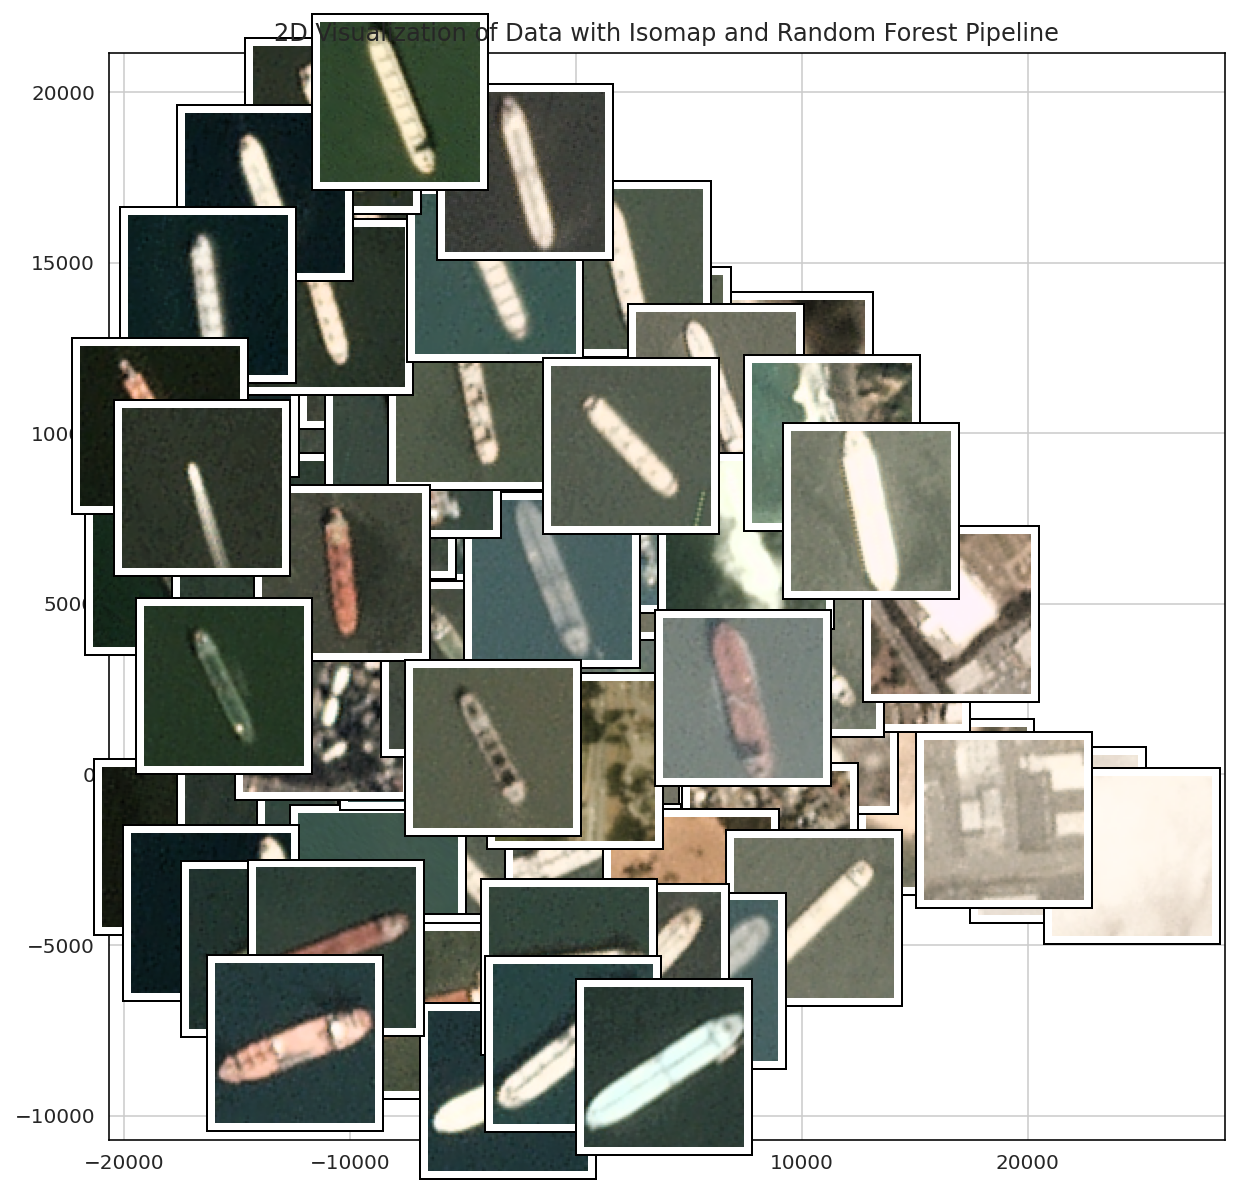

In [71]:
isomap_model = Isomap(n_components=2)  # Set to 2 dimensions for visualization
X_isomap_2d = isomap_model.fit_transform(X_train)

# Visualize using the plot_components function
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(X_train, isomap_model, images=X_train.reshape(-1, 80, 80, 3), ax=ax,
                thumb_frac=0.05, cmap='gray_r')
plt.title("2D Visualization of Data with Isomap and Random Forest Pipeline")
plt.show()

**Interpretation:**

The first two dimensions likely capture variations in the shape and orientation of the ships. Images of ships that have similar shapes and orientations are grouped close together in this 2D space. For example, ships that appear side-by-side with similar lengths and widths may cluster together, while images with ships at different angles may spread out along one axis.

Some clusters of images show ships with different colors or textures. For instance, ships in varying shades (white, red, gray) or with different surroundings (water vs. land background) might be grouped based on color patterns or contrast in texture, indicating that these dimensions also capture color/texture information to some extent.

### What is the overall best pipeline

In [72]:
print("Confusion matrix for random forest classification with all features")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train_rf ))
print("\n")

print("Confusion matrix for Logistic Regression with all features")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train_lr ))
print("\n")

print("Confusion matrix for Decision Tree classification with all features")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train_dt ))
print("\n")

Confusion matrix for random forest classification with all features

Confusion Matrix (Train):
 [[2400    0]
 [   0  800]]


Confusion matrix for Logistic Regression with all features

Confusion Matrix (Train):
 [[2400    0]
 [   0  800]]


Confusion matrix for Decision Tree classification with all features

Confusion Matrix (Train):
 [[2400    0]
 [   0  800]]




In [73]:
print("Confusion matrix for random forest classification with PCA")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train2_rf ))
print("\n")

print("Confusion matrix for Logistic Regression with PCA")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train2_lr ))
print("\n")

print("Confusion matrix for Decision Tree classification with PCAs")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train2_dt ))
print("\n")

Confusion matrix for random forest classification with PCA

Confusion Matrix (Train):
 [[2400    0]
 [   0  800]]


Confusion matrix for Logistic Regression with PCA

Confusion Matrix (Train):
 [[2318   82]
 [ 120  680]]


Confusion matrix for Decision Tree classification with PCAs

Confusion Matrix (Train):
 [[2397    3]
 [  16  784]]




In [74]:
print("Confusion matrix for random forest classification with ISOMAP")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train3_rf ))
print("\n")

print("Confusion matrix for Logistic Regression with ISOMAP")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train3_lr ))
print("\n")

print("Confusion matrix for Decision Tree classification with ISOMAP")
print("\nConfusion Matrix (Train):\n", confusion_matrix(t_train, y_train3_dt ))
print("\n")

Confusion matrix for random forest classification with ISOMAP

Confusion Matrix (Train):
 [[2400    0]
 [   0  800]]


Confusion matrix for Logistic Regression with ISOMAP

Confusion Matrix (Train):
 [[2325   75]
 [ 144  656]]


Confusion matrix for Decision Tree classification with ISOMAP

Confusion Matrix (Train):
 [[2376   24]
 [  88  712]]




In [75]:
def plot_misclassified_samples(X, y_true, y_pred, misclassified_indices, title, label_names=['No Ship', 'Ship']):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    for i, idx in enumerate(misclassified_indices[:15]):  # Show only first 15 misclassified samples
        ax = axes[i // 5, i % 5]
        ax.imshow(X[idx].reshape(80, 80, 3))
        ax.set_title(f"True: {label_names[y_true[idx]]}\nPred: {label_names[y_pred[idx]]}", fontsize=10)
        ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [76]:
misclassified_rf = np.where(t_train != y_train_rf)[0]
print(f"Number of misclassified samples by Random Forest: {len(misclassified_rf)}")

# Identify misclassified samples for Logistic Regression
misclassified_lr = np.where(t_train != y_train_lr)[0]
print(f"Number of misclassified samples by Logistic Regression: {len(misclassified_lr)}")

misclassified_dt = np.where(t_train != y_train_dt)[0]
print(f"Number of misclassified samples by Decision Tree: {len(misclassified_dt)}")

Number of misclassified samples by Random Forest: 0
Number of misclassified samples by Logistic Regression: 0
Number of misclassified samples by Decision Tree: 0


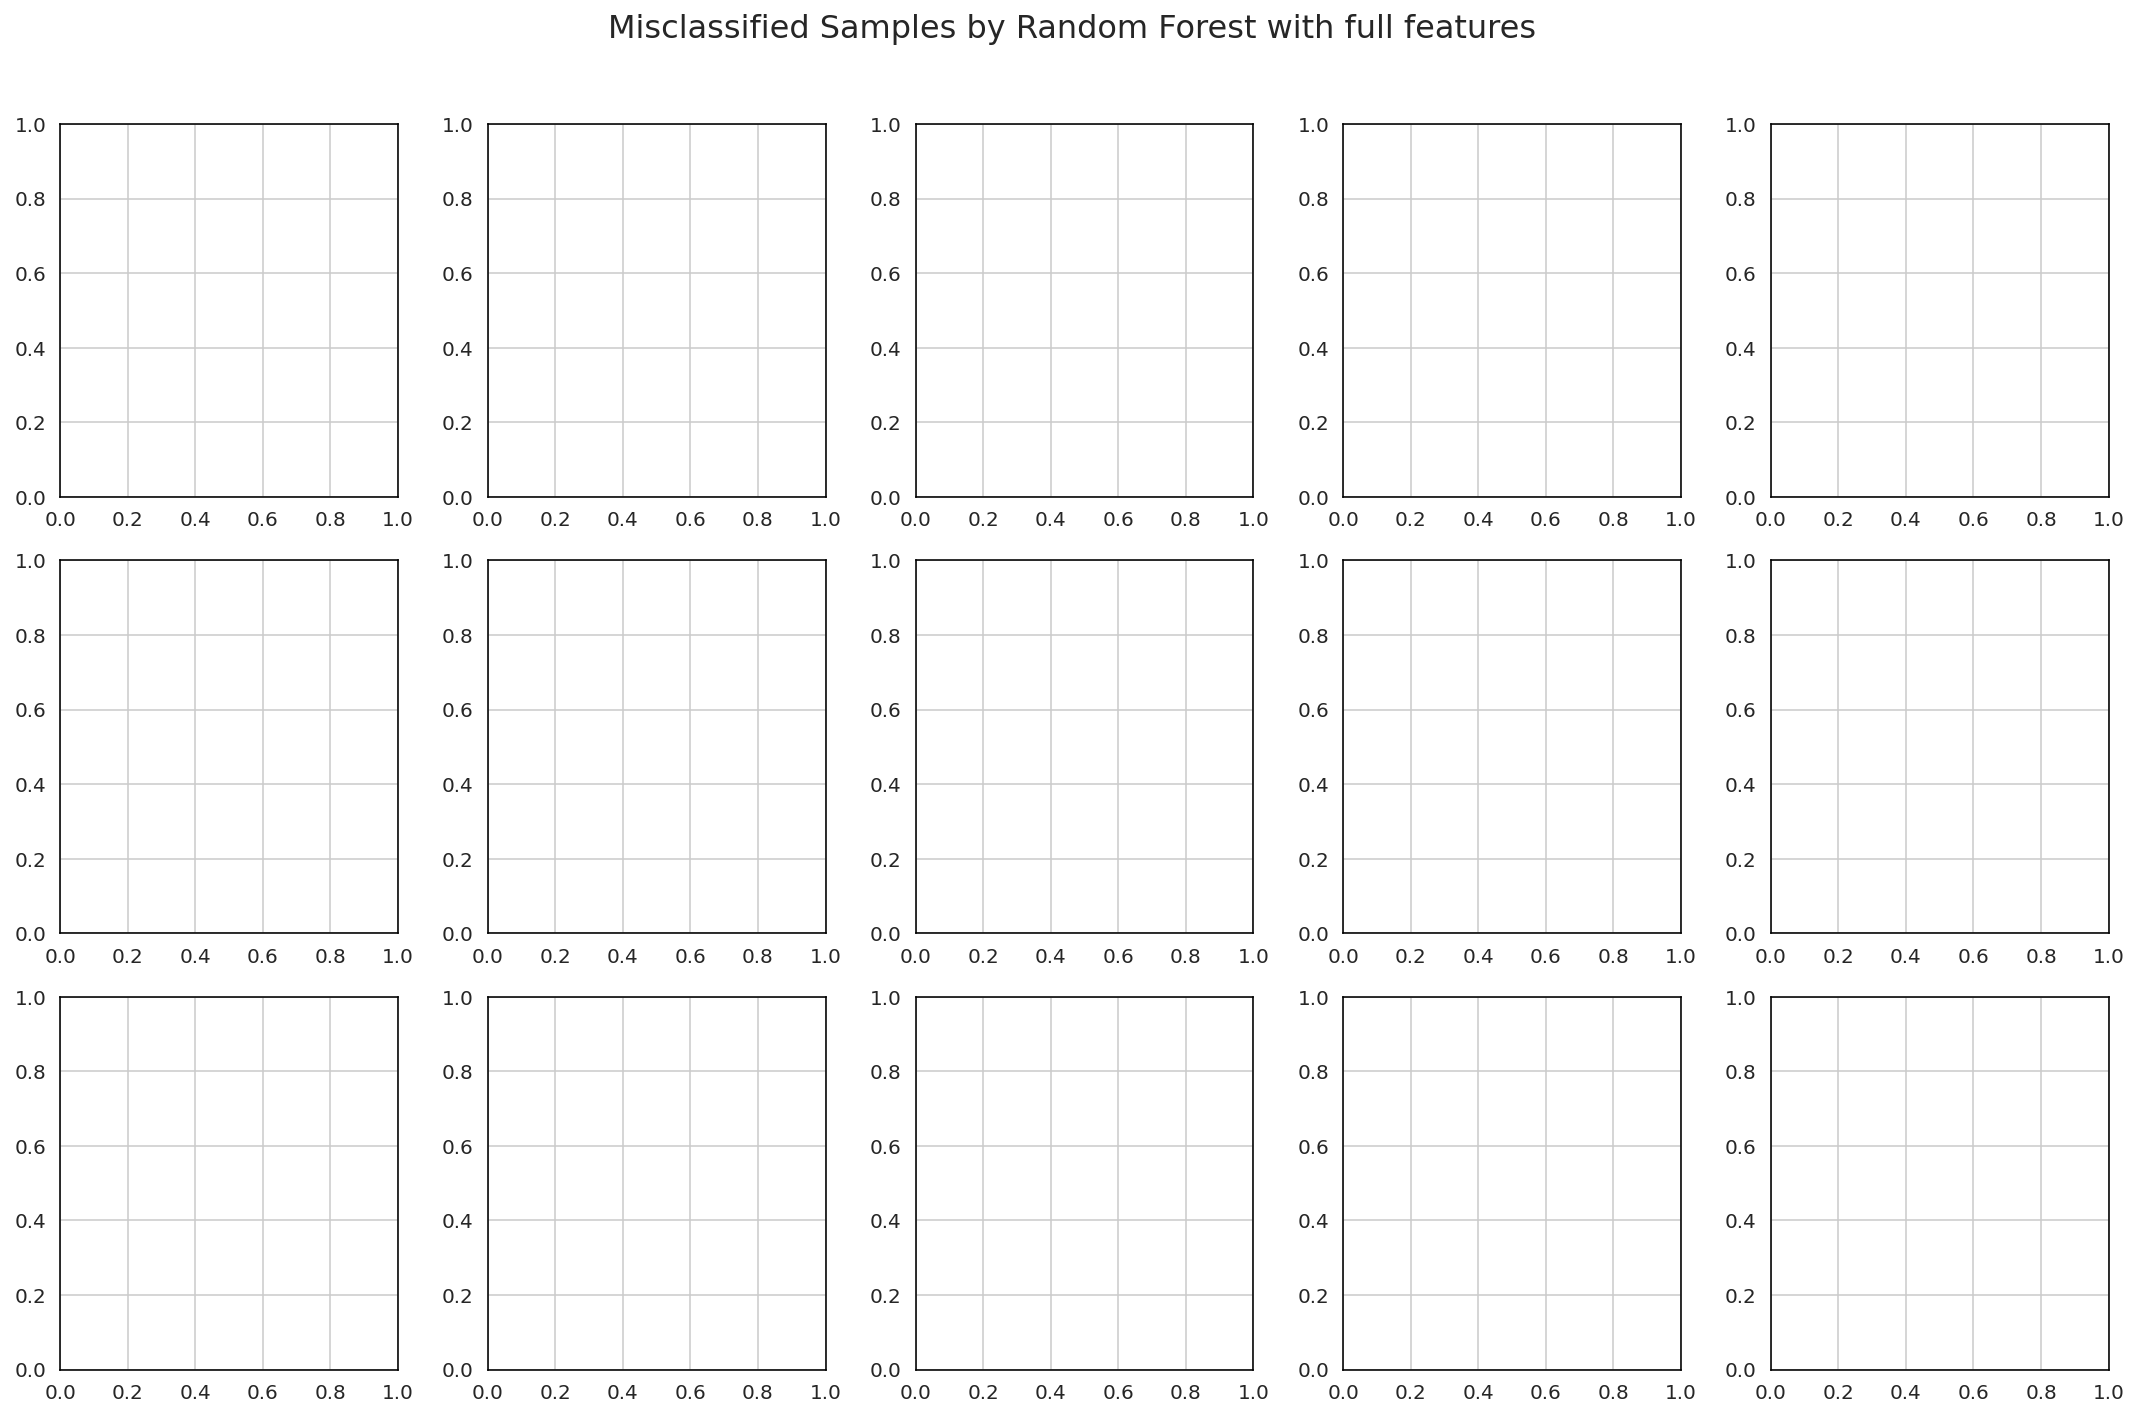

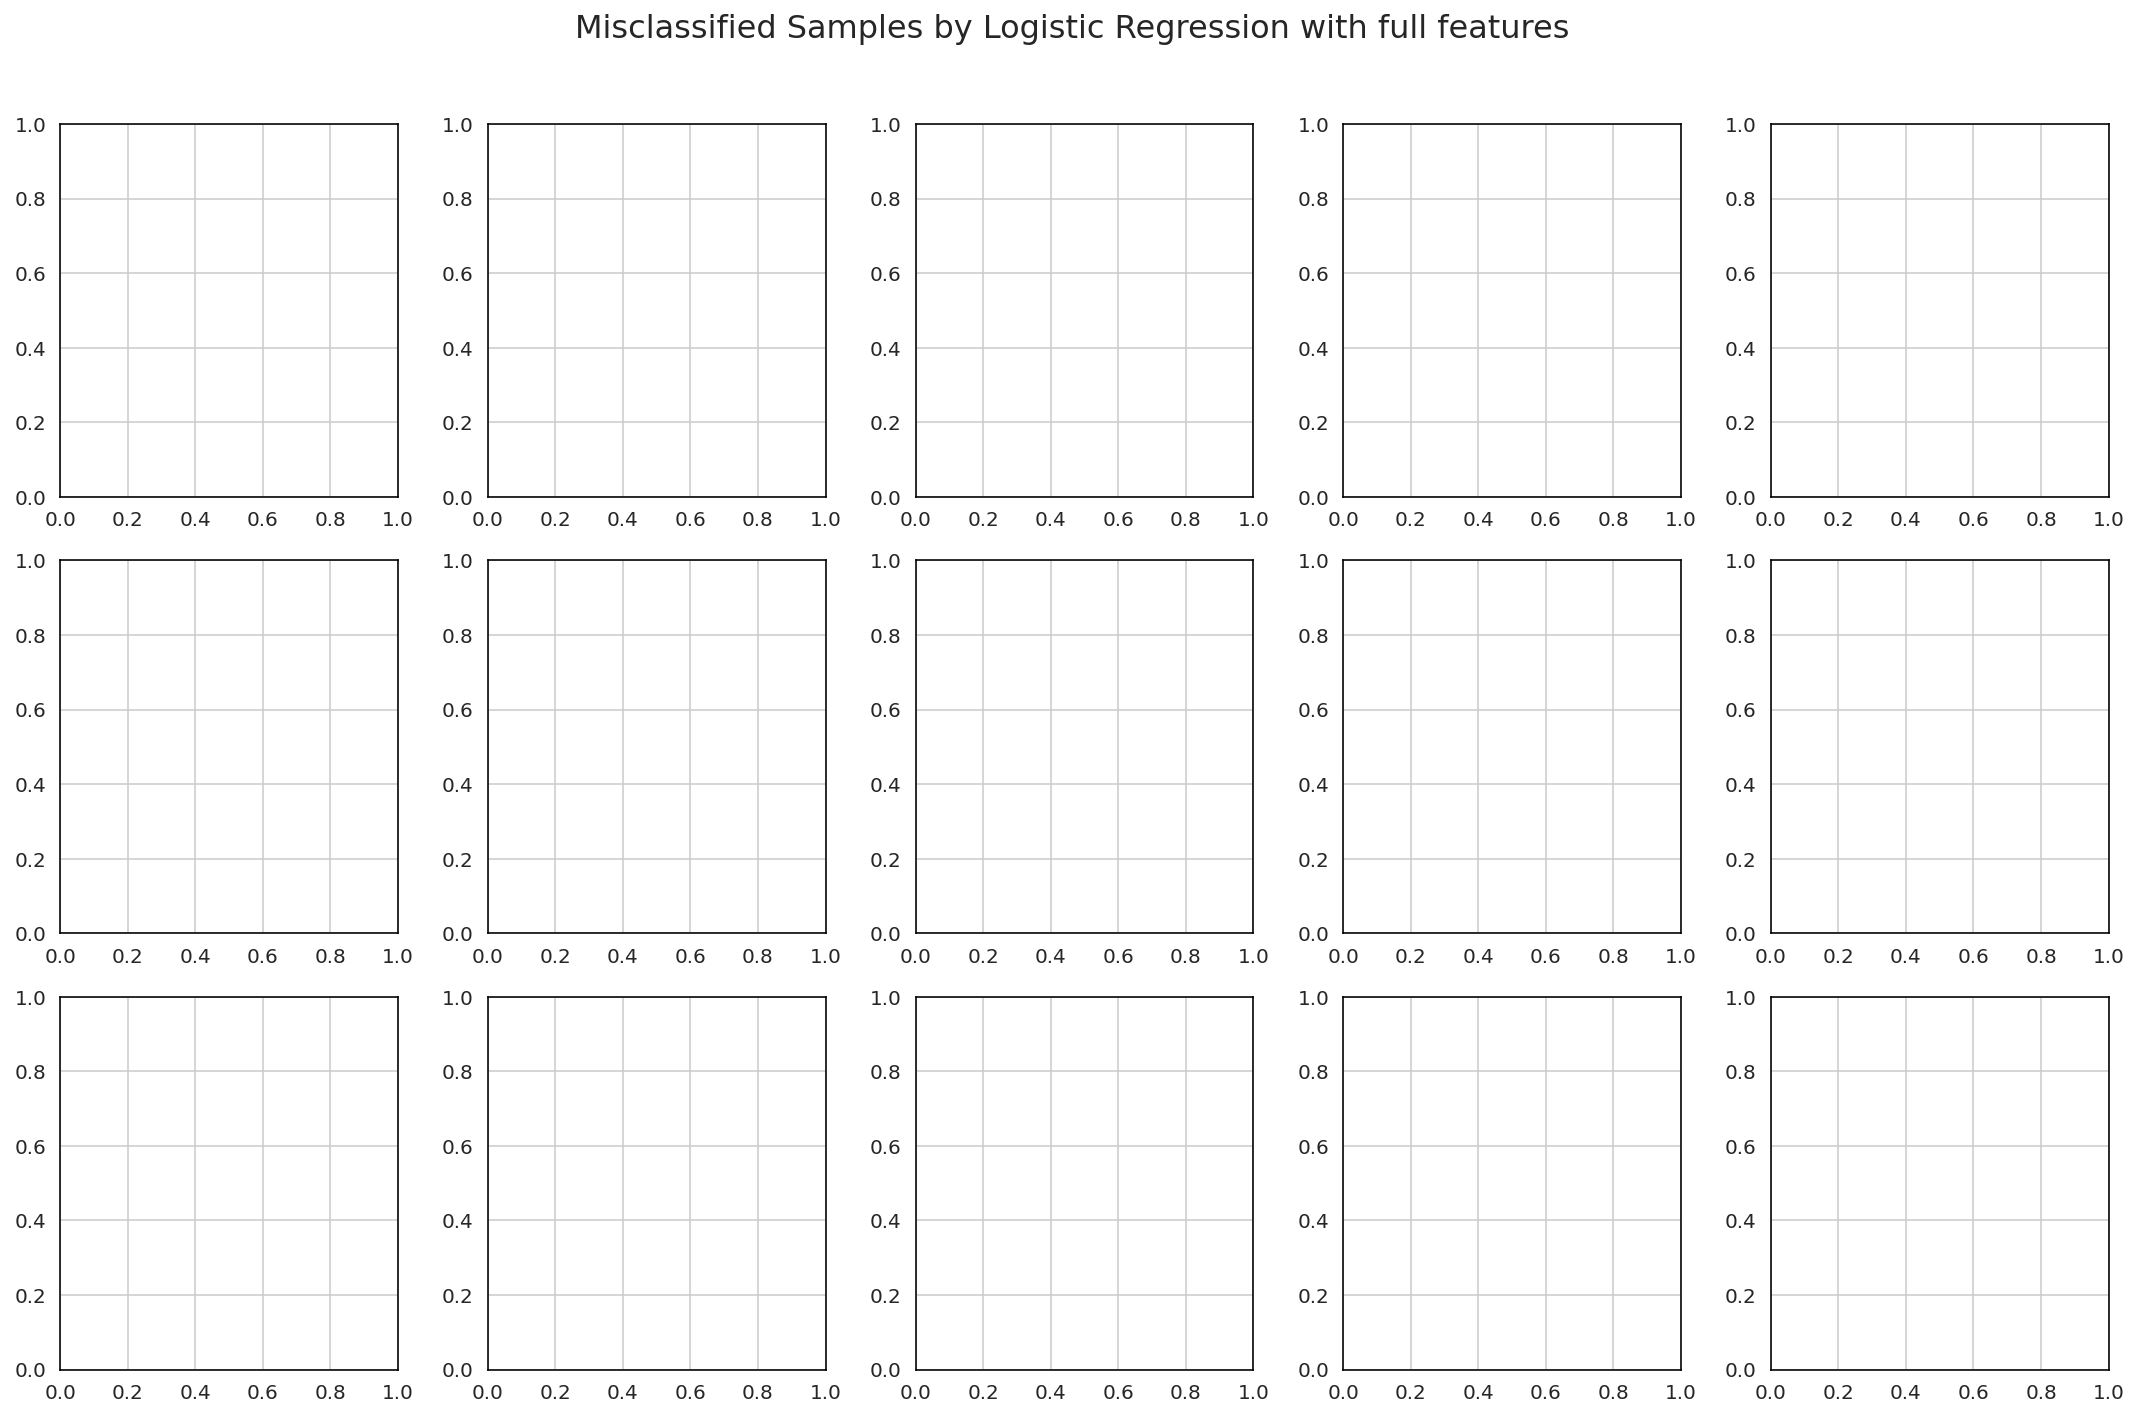

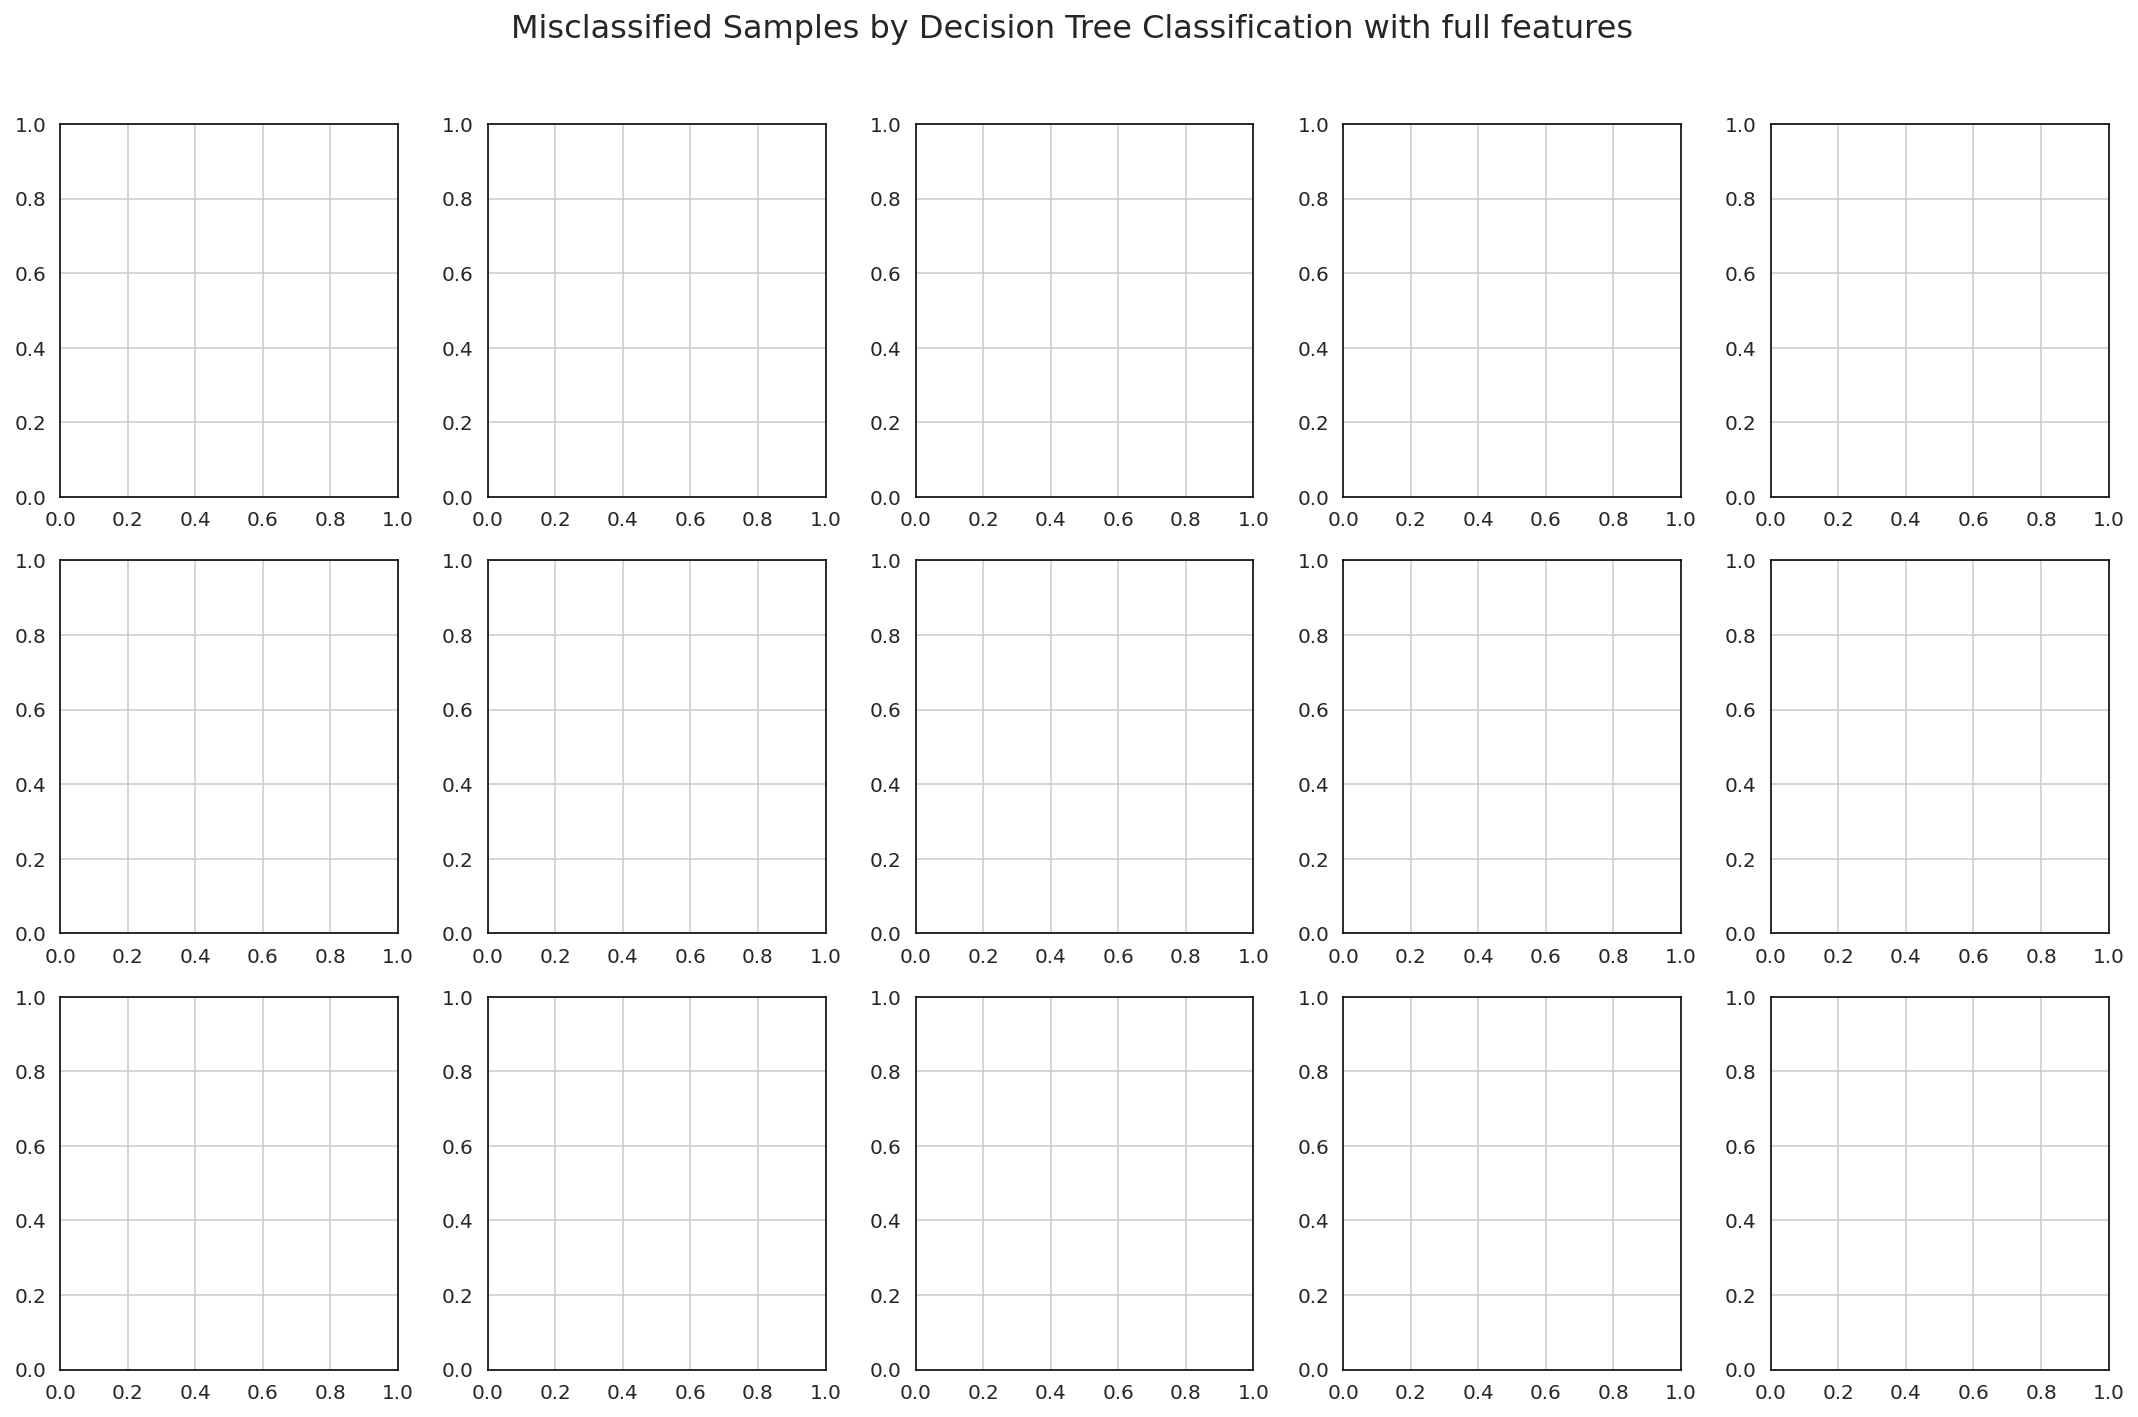

In [77]:
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train_rf, misclassified_rf,
                           title="Misclassified Samples by Random Forest with full features")

# Plot misclassified samples for Logistic Regression
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train_lr, misclassified_lr,
                           title="Misclassified Samples by Logistic Regression with full features")

plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train_dt, misclassified_dt,
                           title="Misclassified Samples by Decision Tree Classification with full features")

In [78]:
misclassified_rf2 = np.where(t_train != y_train2_rf)[0]
print(f"Number of misclassified samples by Random Forest with PCA: {len(misclassified_rf2)}")

# Identify misclassified samples for Logistic Regression
misclassified_lr2 = np.where(t_train != y_train2_lr)[0]
print(f"Number of misclassified samples by Logistic Regression with PCA: {len(misclassified_lr2)}")

misclassified_dt2 = np.where(t_train != y_train2_dt)[0]
print(f"Number of misclassified samples by Decision Tree with PCA: {len(misclassified_dt2)}")

Number of misclassified samples by Random Forest with PCA: 0
Number of misclassified samples by Logistic Regression with PCA: 202
Number of misclassified samples by Decision Tree with PCA: 19


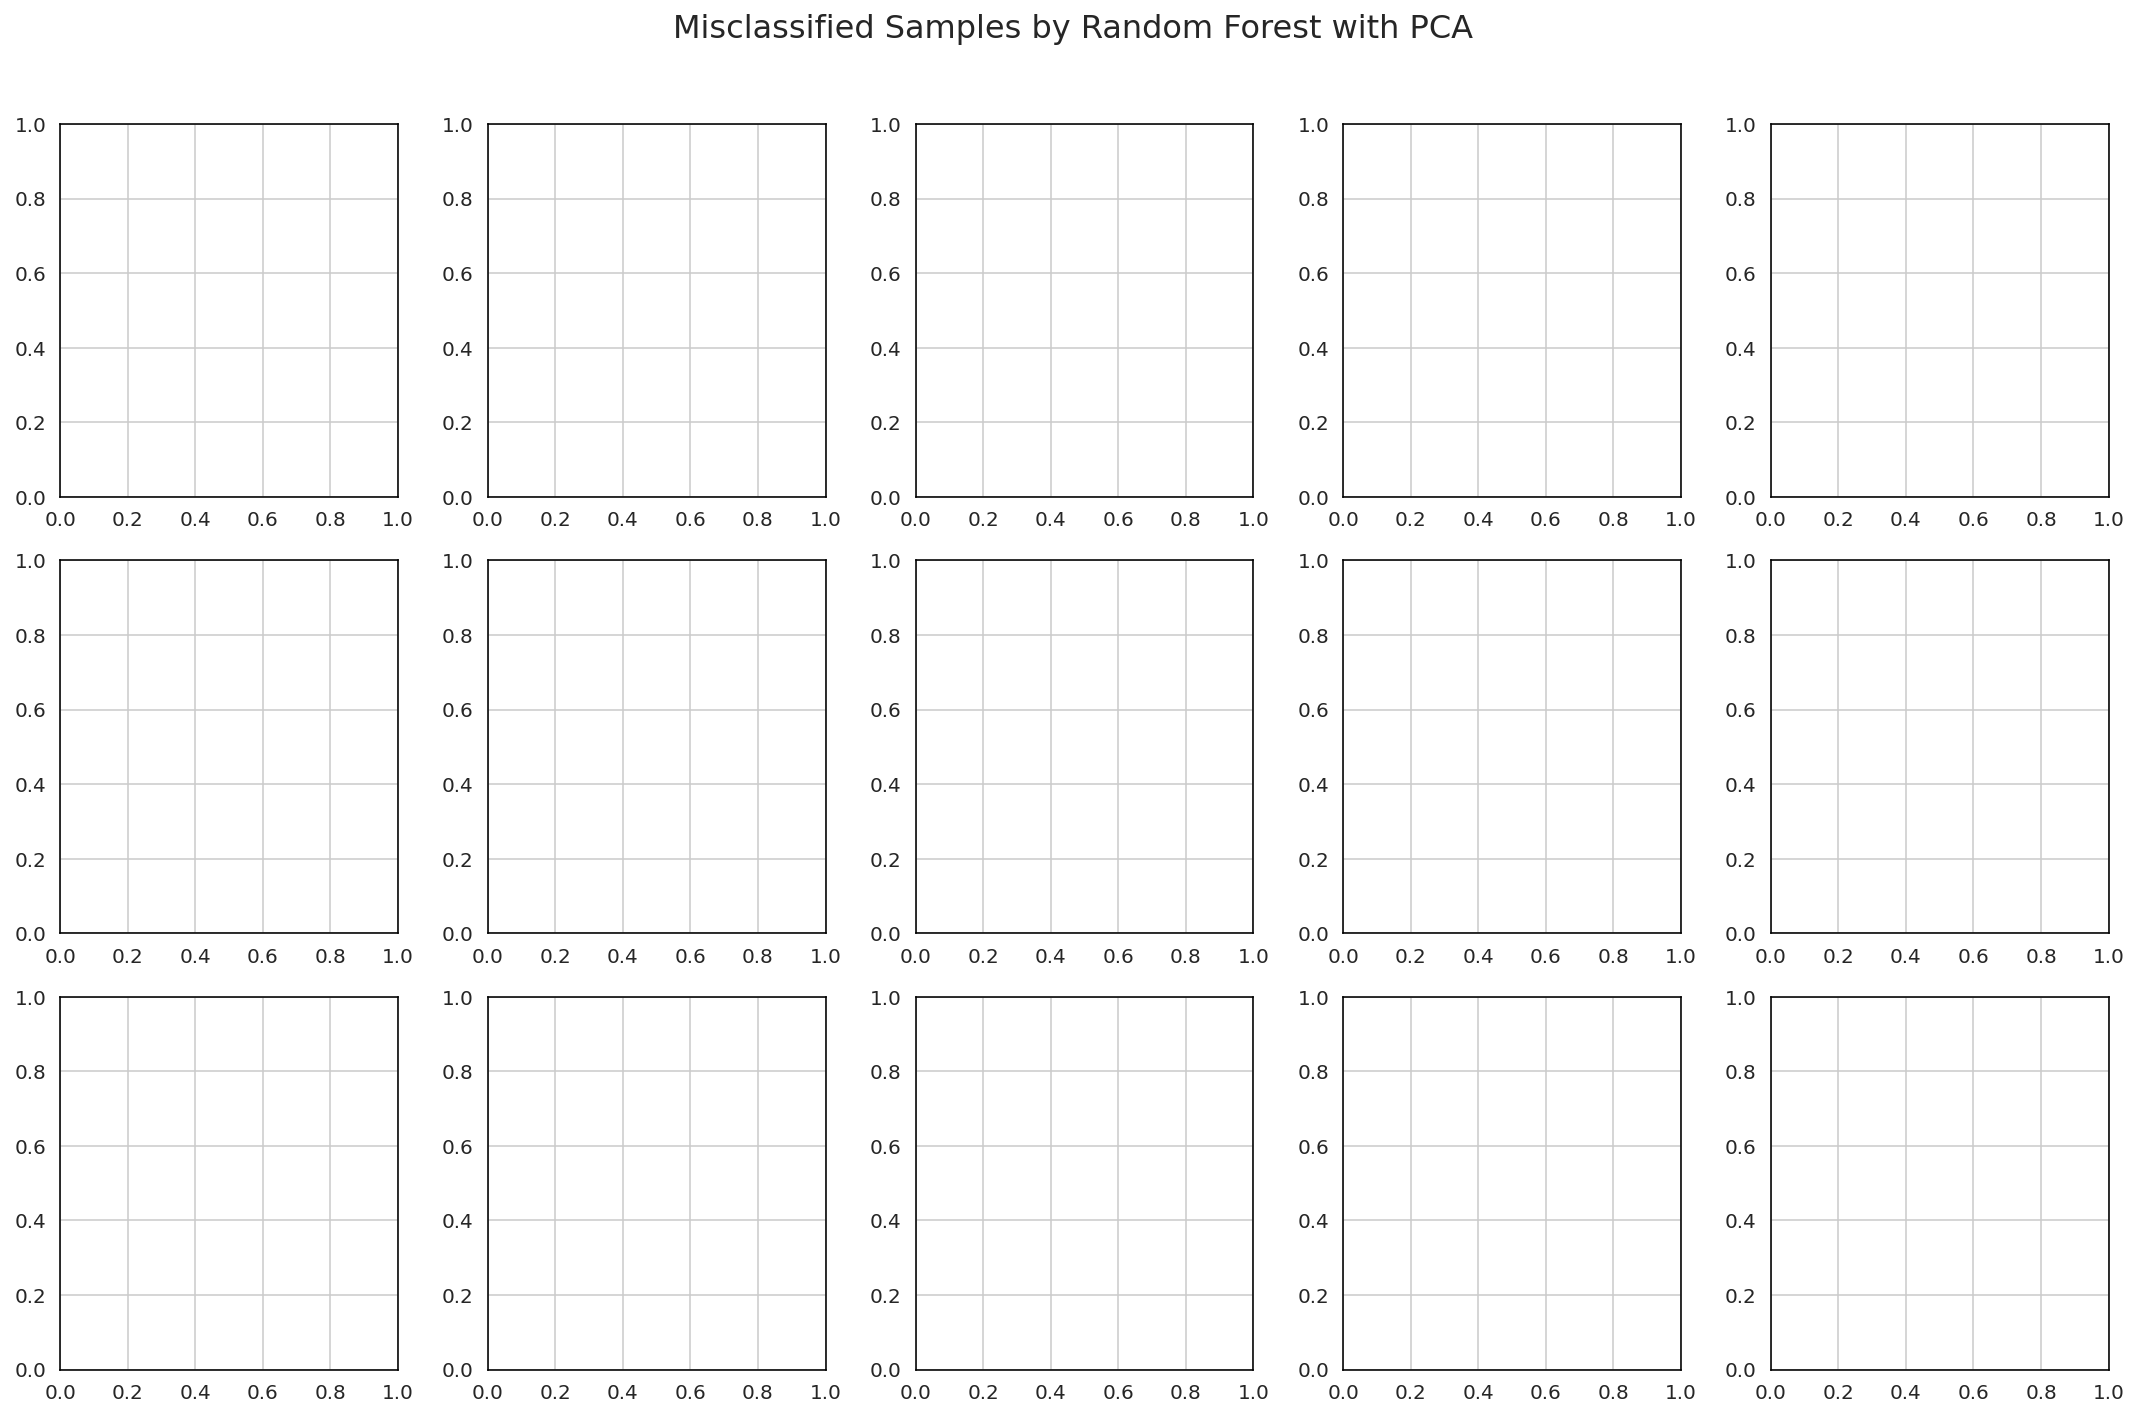

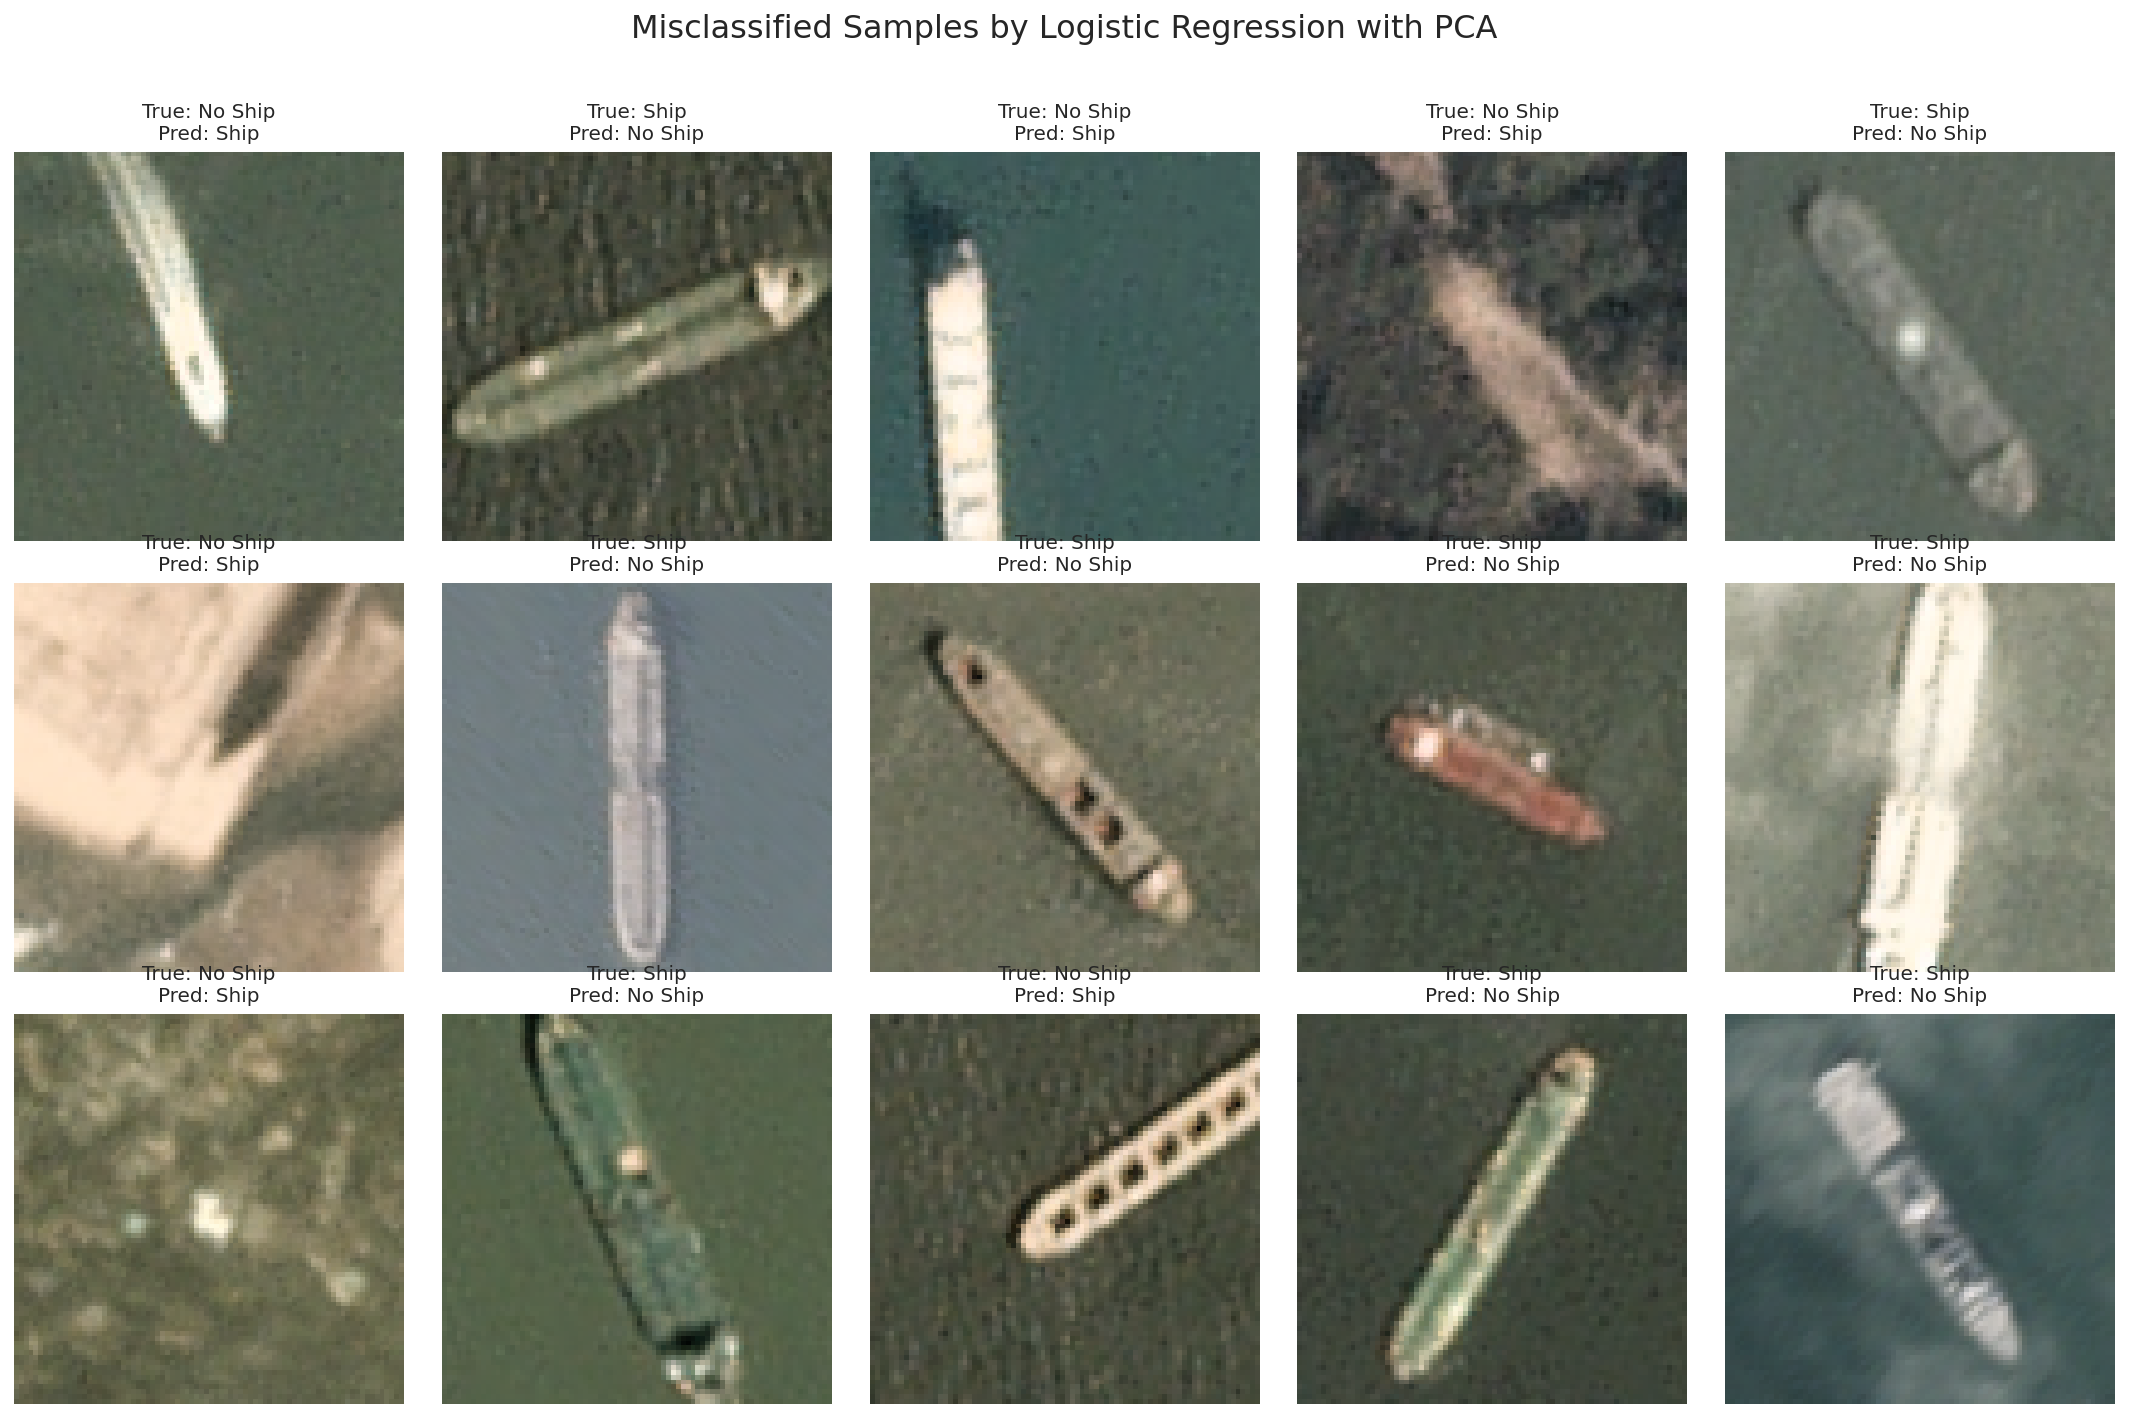

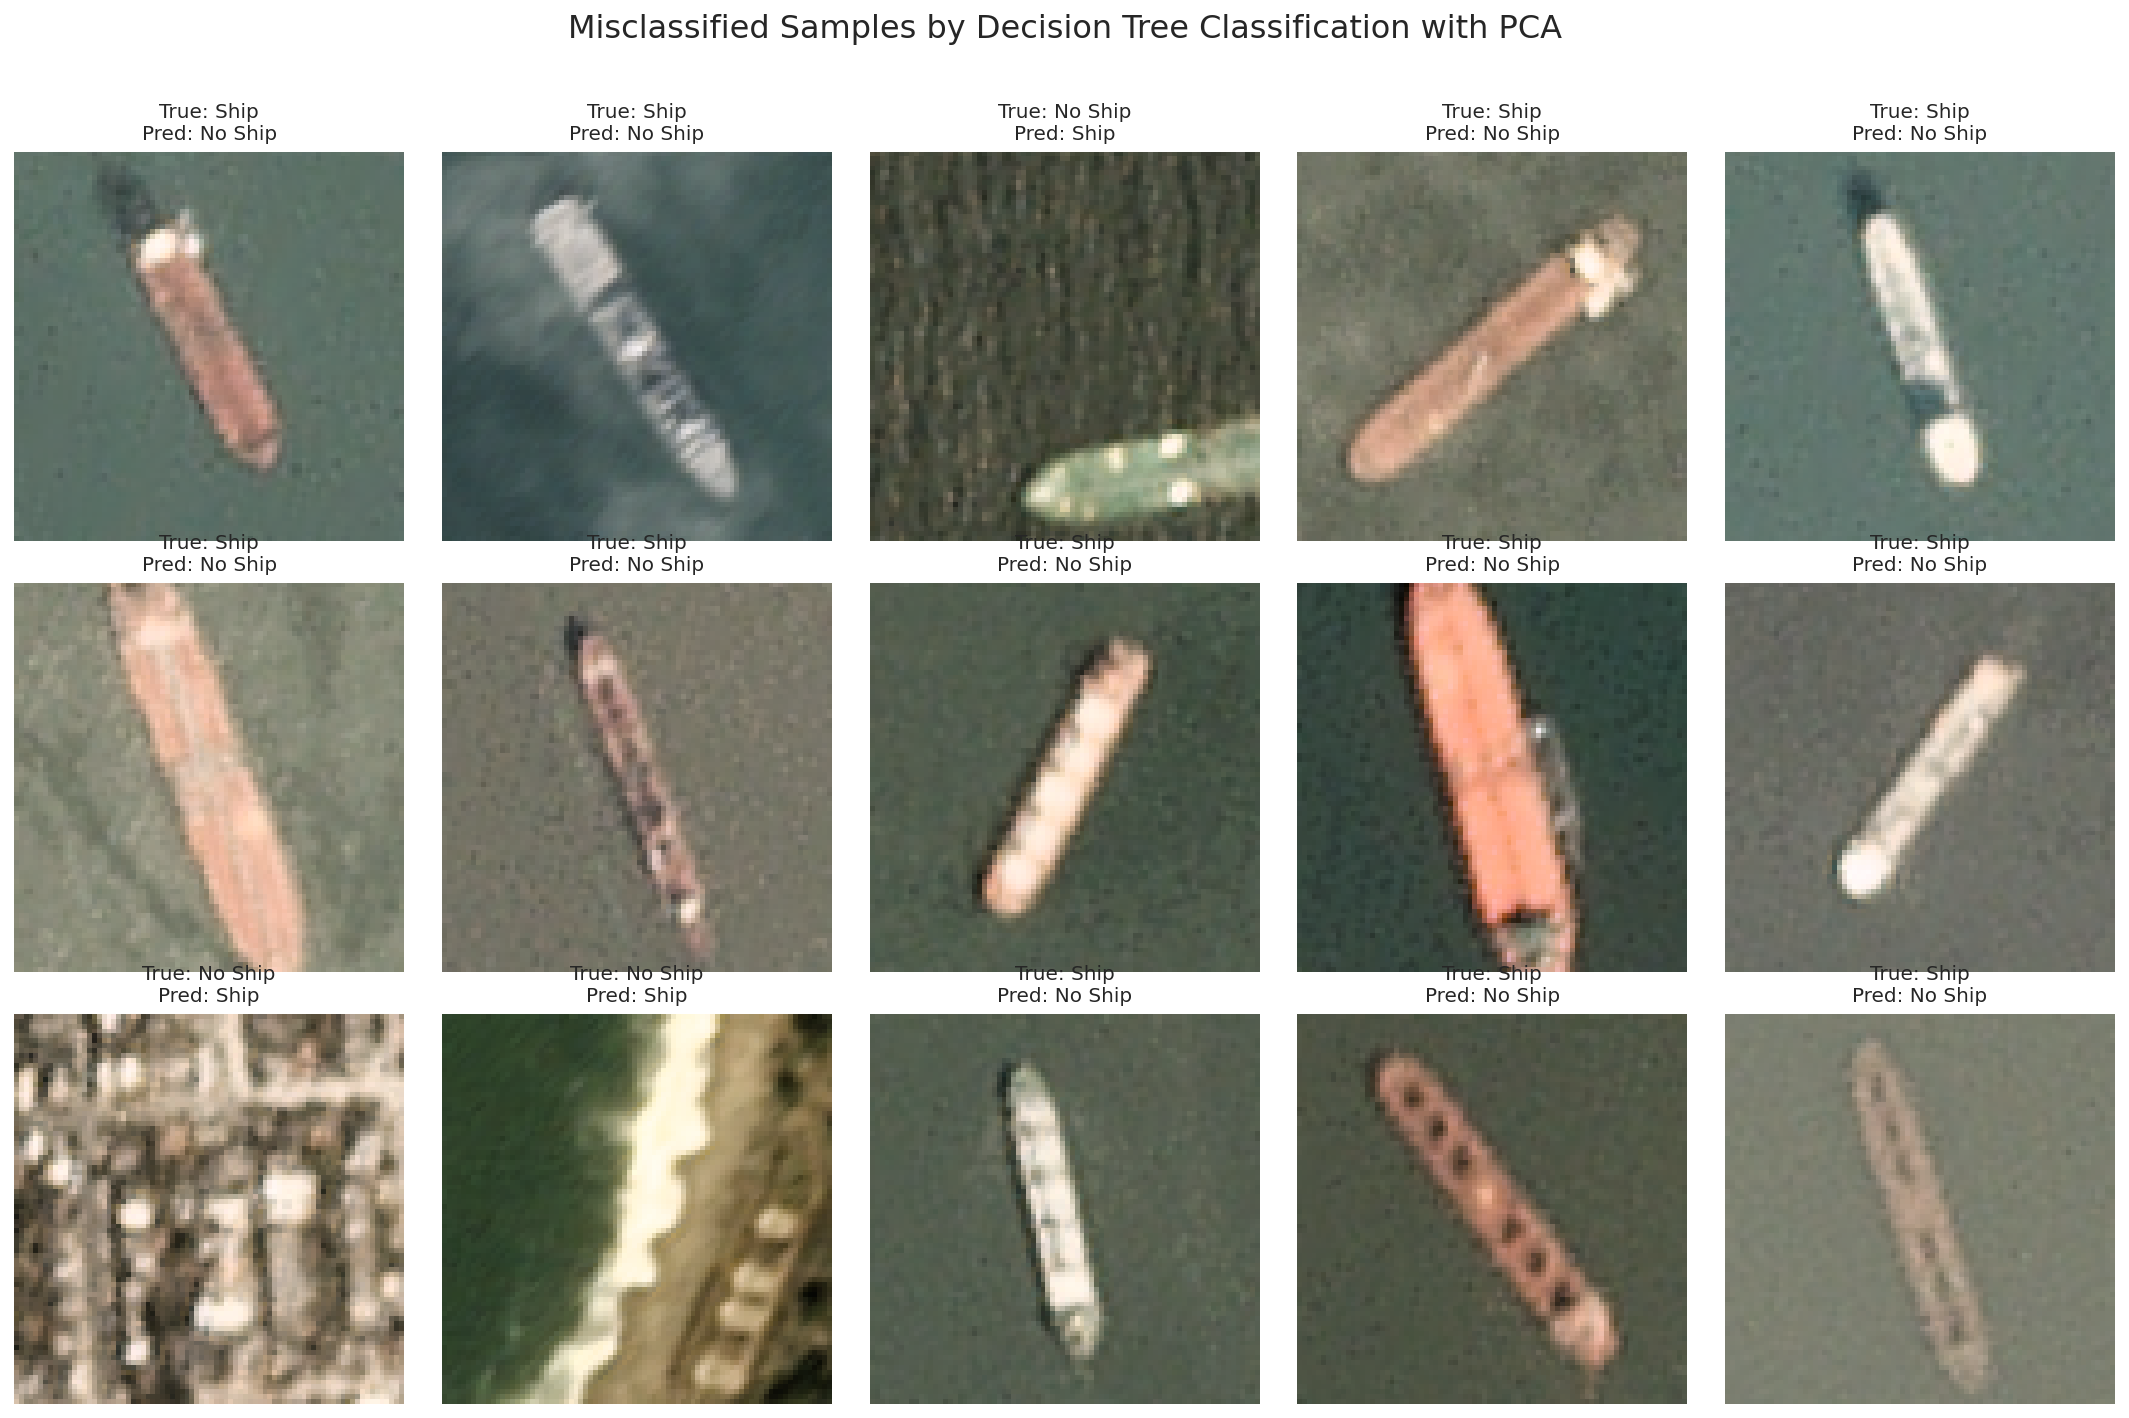

In [79]:
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train2_rf, misclassified_rf2,
                           title="Misclassified Samples by Random Forest with PCA")

# Plot misclassified samples for Logistic Regression
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train2_lr, misclassified_lr2,
                           title="Misclassified Samples by Logistic Regression with PCA")

plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train2_dt, misclassified_dt2,
                           title="Misclassified Samples by Decision Tree Classification with PCA")

**Pattern in the misclassification:**
1. Some images of ships were misclassified as "No Ship" (e.g., row 1, column 1; row 1, column 4; row 2, column 2). These images often have ships that blend into the background due to similar colors or lower contrast, making them harder to distinguish.
2. Similarly, some "No Ship" images that contain structures or water patterns resembling parts of a ship were classified as "Ship" (e.g., row 1, column 2; row 3, column 1). This shows the model may be influenced by shapes and colors that are typically associated with ships but appear in non-ship images as well.

**Possible solutions:**
1. Using a non-linear dimensionality reduction technique (like Isomap) might capture more complex, non-linear patterns that can help separate ships from non-ships, especially when backgrounds are similar.
2. Techniques such as rotation, brightness adjustment, and contrast enhancement could help the model generalize better and become less sensitive to background noise and lighting differences.
3. Adjusting hyperparamteter tuning could enhance the results as well.

In [80]:
misclassified_rf3 = np.where(t_train != y_train3_rf)[0]
print(f"Number of misclassified samples by Random Forest with ISOMAP: {len(misclassified_rf3)}")

# Identify misclassified samples for Logistic Regression
misclassified_lr3 = np.where(t_train != y_train3_lr)[0]
print(f"Number of misclassified samples by Logistic Regression with ISOMAP: {len(misclassified_lr3)}")

misclassified_dt3 = np.where(t_train != y_train3_dt)[0]
print(f"Number of misclassified samples by Decision Tree with ISOMAP: {len(misclassified_dt3)}")

Number of misclassified samples by Random Forest with ISOMAP: 0
Number of misclassified samples by Logistic Regression with ISOMAP: 219
Number of misclassified samples by Decision Tree with ISOMAP: 112


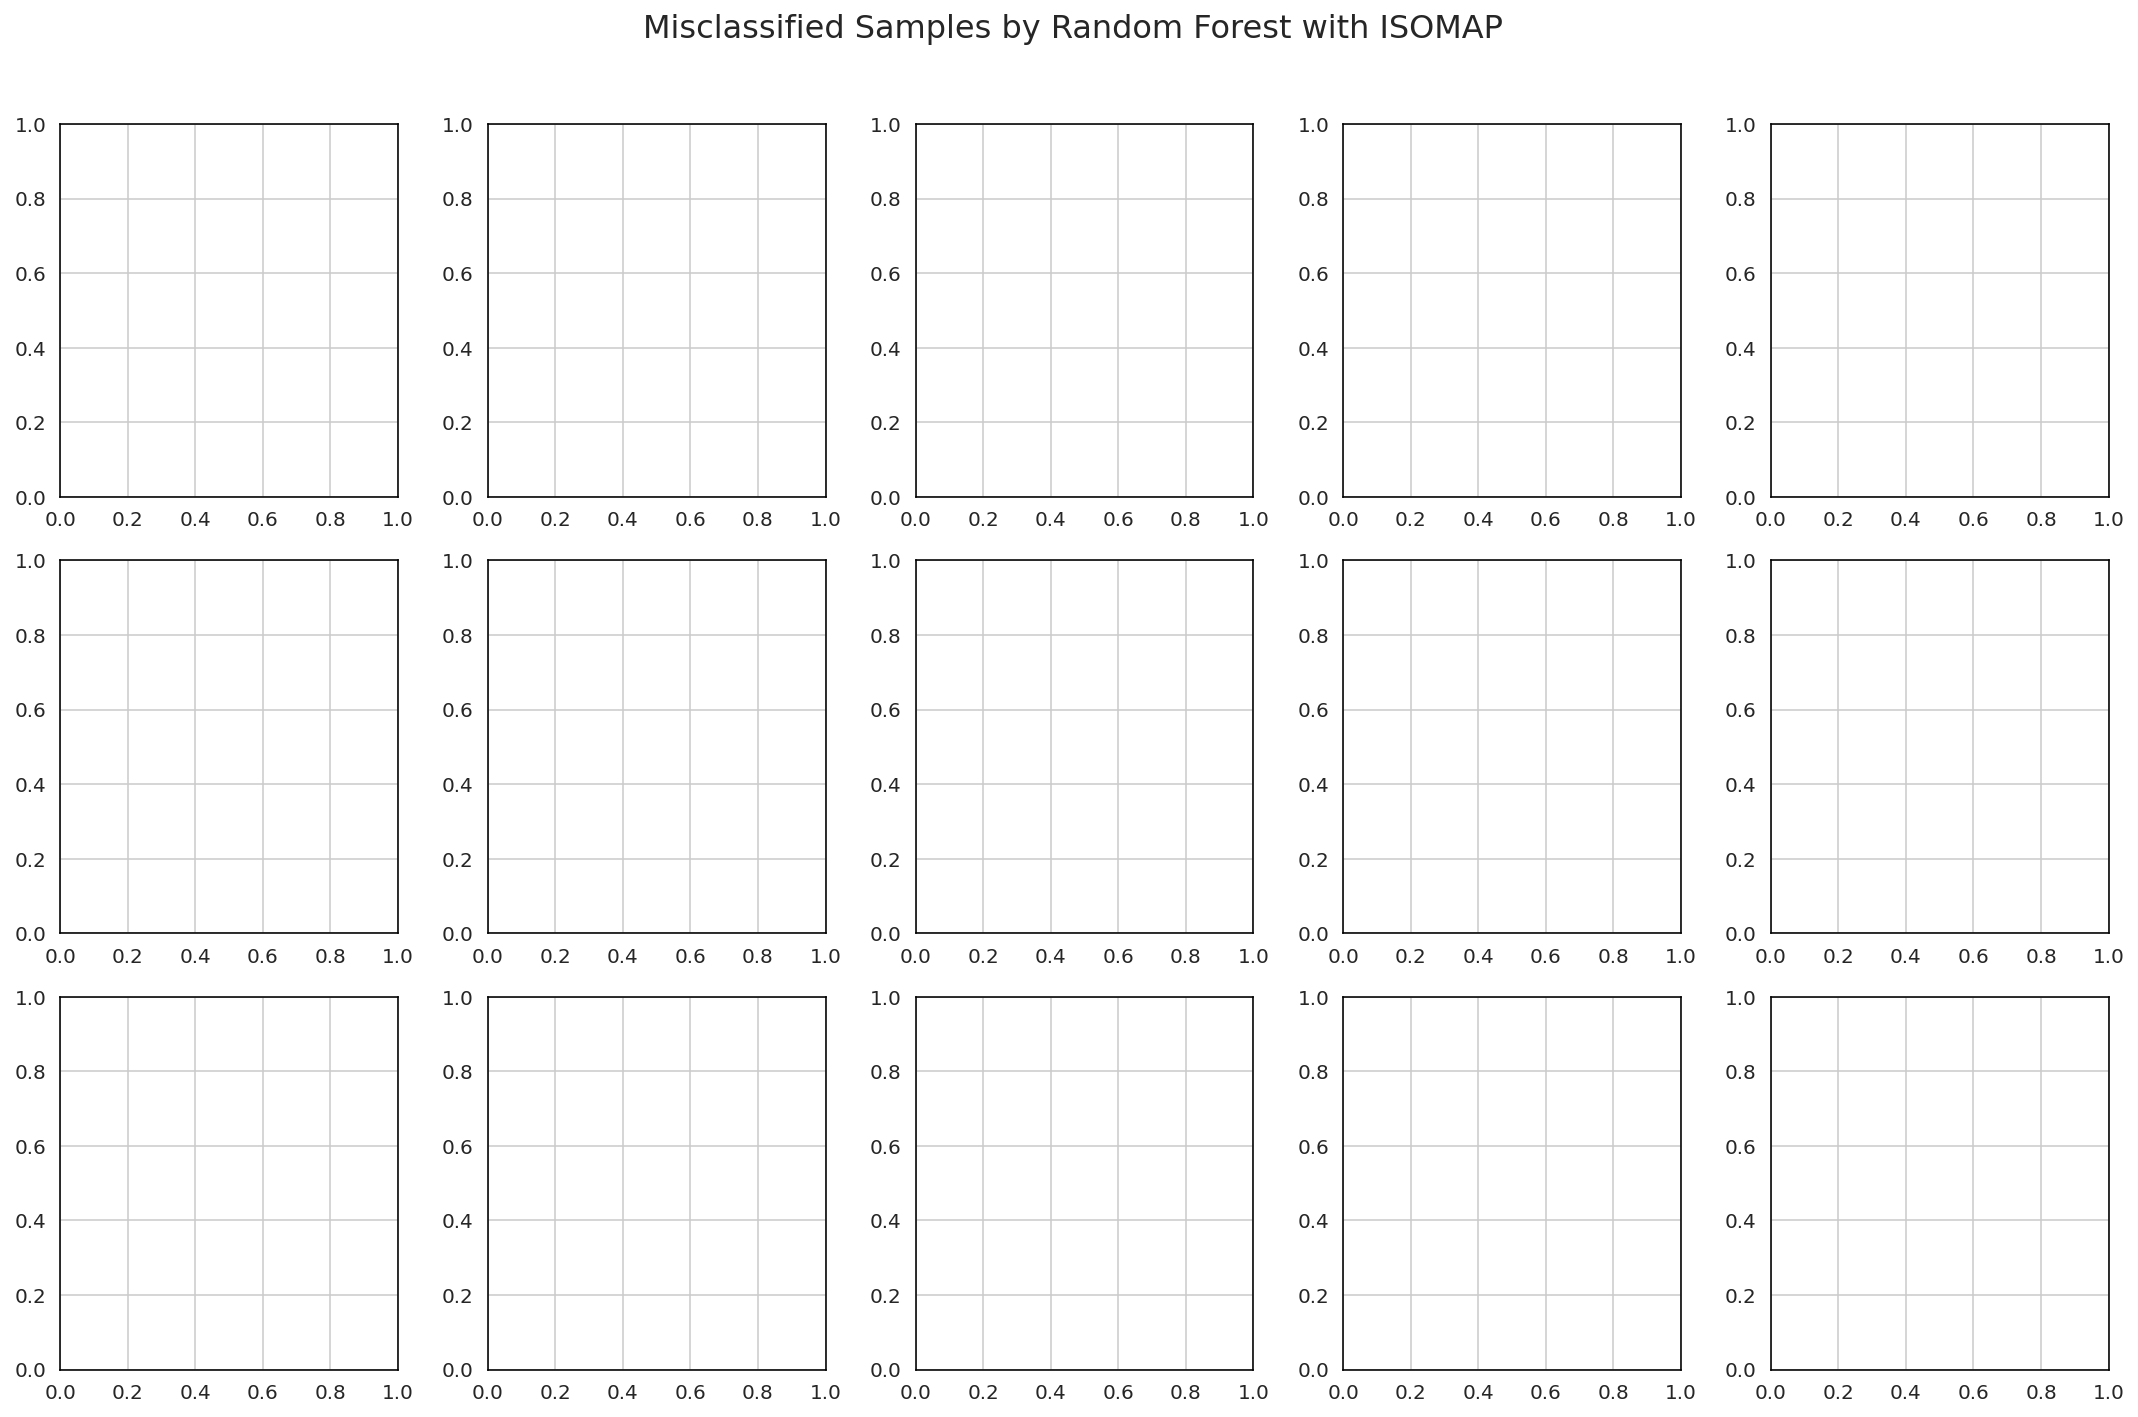

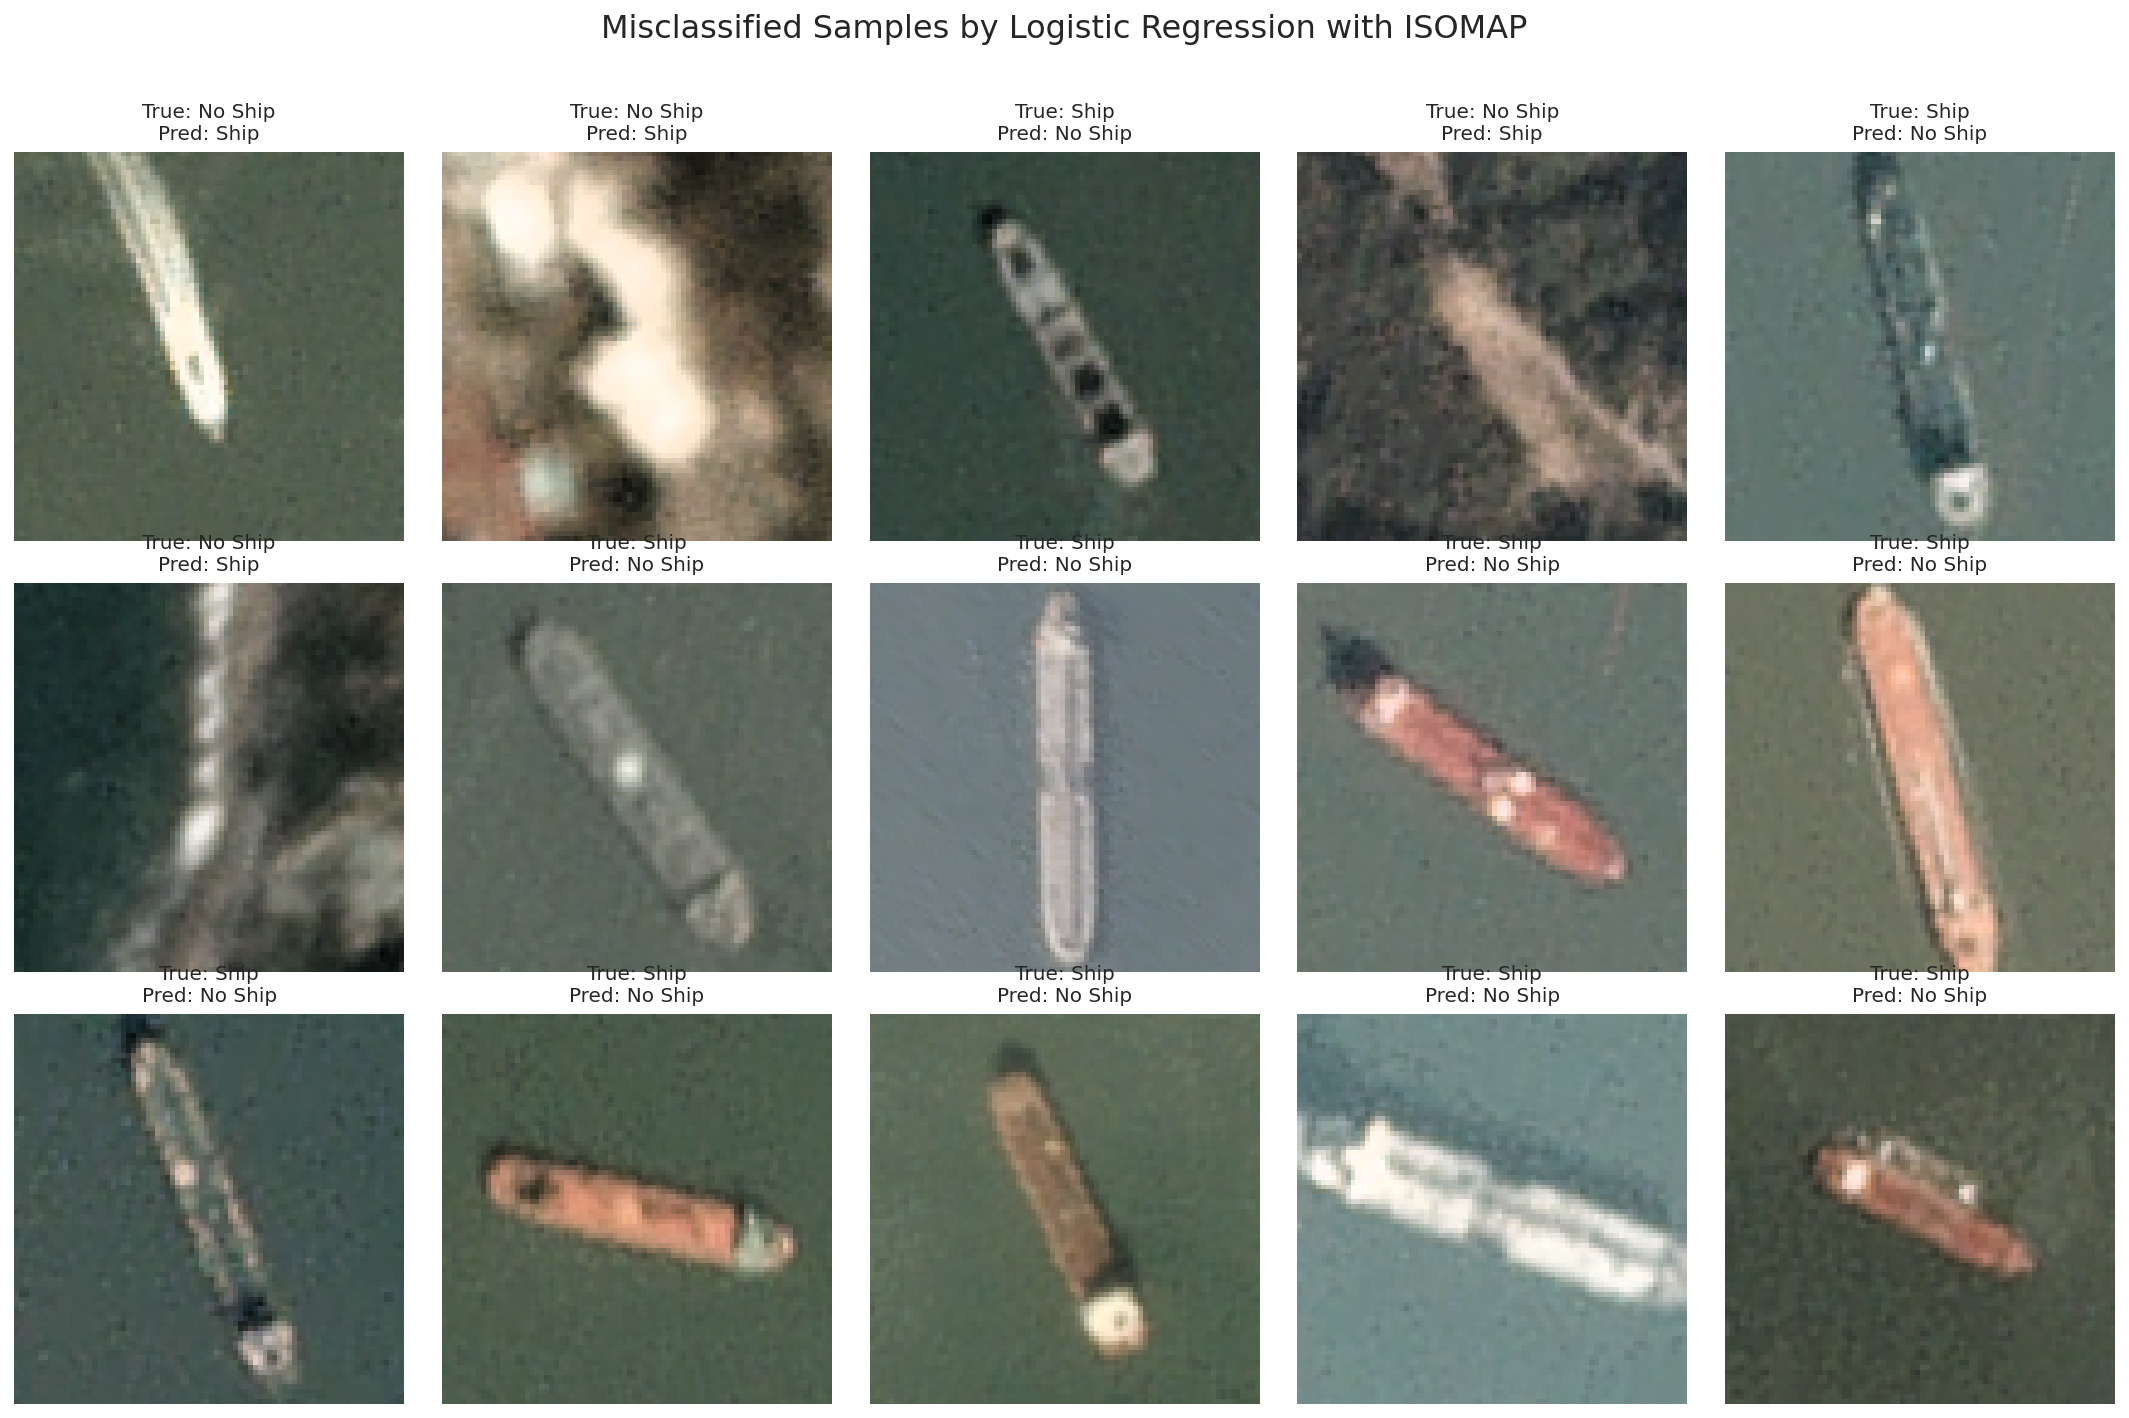

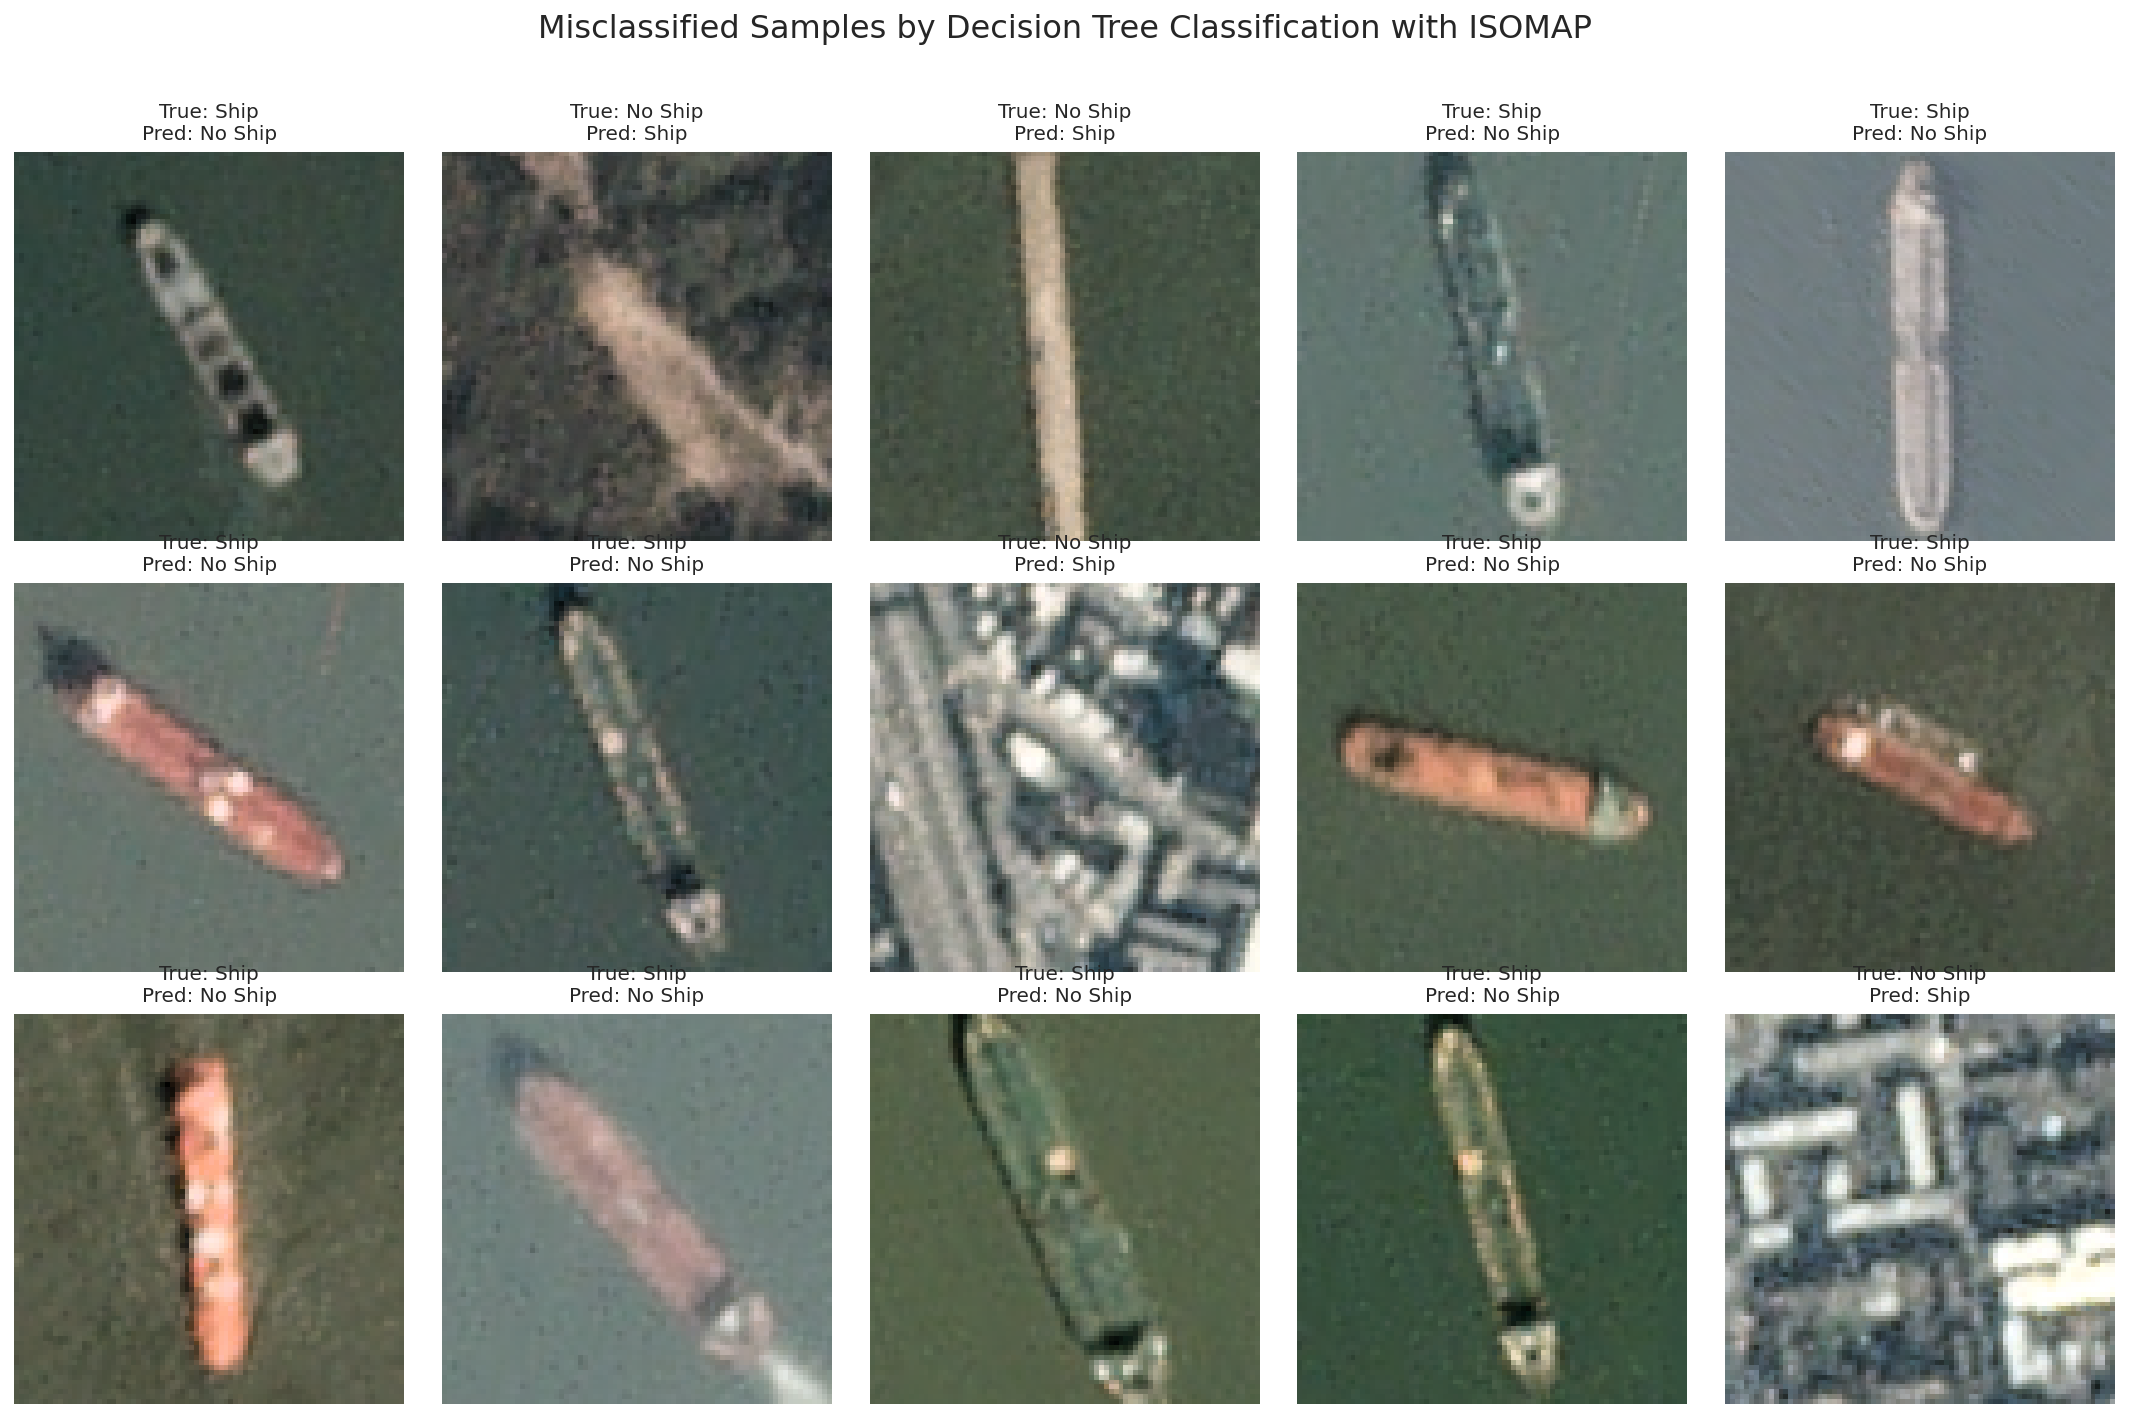

In [81]:
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train3_rf, misclassified_rf3,
                           title="Misclassified Samples by Random Forest with ISOMAP")

# Plot misclassified samples for Logistic Regression
plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train3_lr, misclassified_lr3,
                           title="Misclassified Samples by Logistic Regression with ISOMAP")

plot_misclassified_samples(X_train.reshape(-1, 80, 80, 3), t_train, y_train3_dt, misclassified_dt3,
                           title="Misclassified Samples by Decision Tree Classification with ISOMAP")

**Observed Patterns in Misclassified Samples**
1. Several images of ships that were classified as "No Ship" (e.g., row 1, columns 1 and 5; row 2, columns 2 and 4) show ships blending into their surroundings due to similar colors or low contrast against the water. This likely caused the Isomap transformation to fail at capturing distinctive features for these ships, resulting in misclassification.
2. Similarly, "No Ship" images with certain textures or patterns similar to ships (e.g., row 1, columns 2 and 3) were classified as ships, possibly because the Isomap model emphasized these textures or shapes.
3. Ships with unusual or less common shapes, such as broader or differently colored ships (e.g., row 2, columns 5), are sometimes classified as "No Ship." This suggests that the model may not have learned to generalize across different types of ships.

**Possible solutions:**
1. While Isomap is a non-linear dimensionality reduction method, it may not be the most effective for capturing intricate, non-linear relationships in image data. Techniques like t-SNE might better preserve complex structures in the data.
2. Since ships in the images may appear at different angles or sizes, augmentation techniques such as rotation and scaling could improve the model's ability to generalize to different views and sizes.
3. Applying brightness and contrast variations to the training images can help the model become more robust to different lighting conditions.
4. Adjusting hyperparamteter tuning could enhance the results as well.

Best possible pipleine based on training performance is Decision Tree with PCA. Even though Ranom forest has the highest accuracy, f1 score, precision and recall they are indicators of overfitting. Among the other models, logistic regression and decision tree classifier, decision tree with PCA has significantly better performance and faster training time as well. Hence, Decision tree classifier with PCA is best based on training performance.